#### Notebook setup

In [1]:
# %pip install -e .

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from multirotor.helpers import control_allocation_matrix, DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from multirotor.trajectories import Trajectory
from multirotor.visualize import plot_datalog

/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Plotting/display parameters
# https://stackoverflow.com/a/21009774/4591810
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Parameters

In [4]:
# Tarot T18 params
bp = BatteryParams(max_voltage=22.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0347,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi,
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.01, g=9.81)

### Multirotor

Simulating individual components of the multirotor. These make up the final `Multirotor` object.

#### Motor

Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/all

Text(0.5, 0, 'Time /ms')

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/allanzhang/miniconda3/envs/uav/lib/python3.11/site-packages/matplotlib/mpl-da

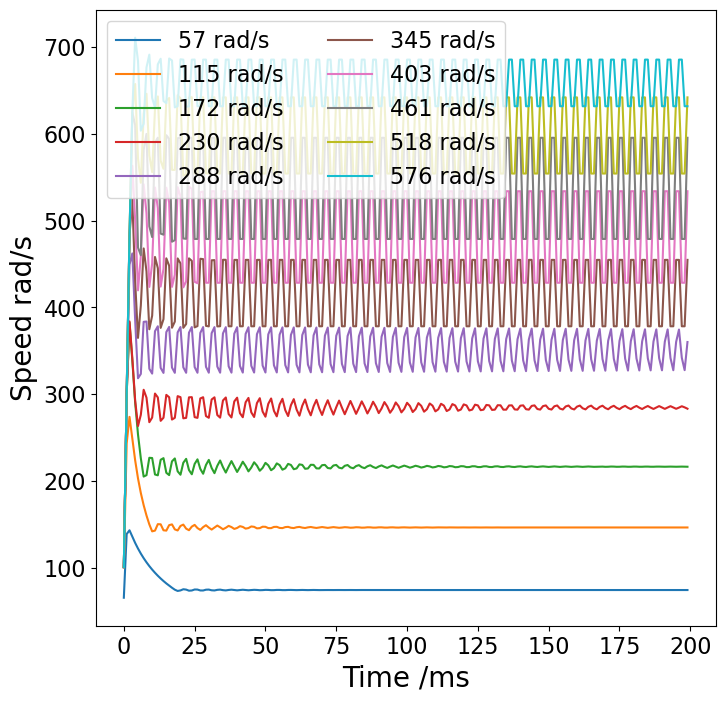

In [5]:
%matplotlib inline
# Plot motor speeds as a function of time and input voltage signal
plt.figure(figsize=(8,8))
motor = Motor(mp, sp)
for vsignal in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    speeds = []
    motor.reset()
    speed = vsignal / mp.speed_voltage_scaling
    for i in range(200):
        speeds.append(motor.step(speed))
    plt.plot(speeds, label='%d rad/s' % speed)
plt.legend(ncol=2)
plt.ylabel('Speed rad/s')
plt.xlabel('Time /ms')

Learning a linear relationship for the equation $V = k_{scaling} * speed$ for motors. This is useful for `SpeedsMultirotorEnv` which takes speed signals as the input. This constant converts speeds to applied voltages. The default value in`MotorParams` is 1, meaning the actions are voltage signals.

In [6]:
from multirotor.helpers import learn_speed_voltage_scaling

def make_motor_fn(params, sp):
    from copy import deepcopy
    params = deepcopy(params)
    params.speed_voltage_scaling = 1.
    def motor_step(signal):
        m = Motor(params, sp)
        for i in range(100):
            s = m.step(signal)
        return s
    return motor_step

print('Voltage = %.5f * speed' % (learn_speed_voltage_scaling(make_motor_fn(mp, sp))))

'Voltage = 0.02862 * speed'


#### Propeller

The propeller can use a numerically solved thrust relationship, where thrust depends on airspeed. Or the easier option of using thrust coefficient is available.

Loaded backend module://matplotlib_inline.backend_inline version unknown.


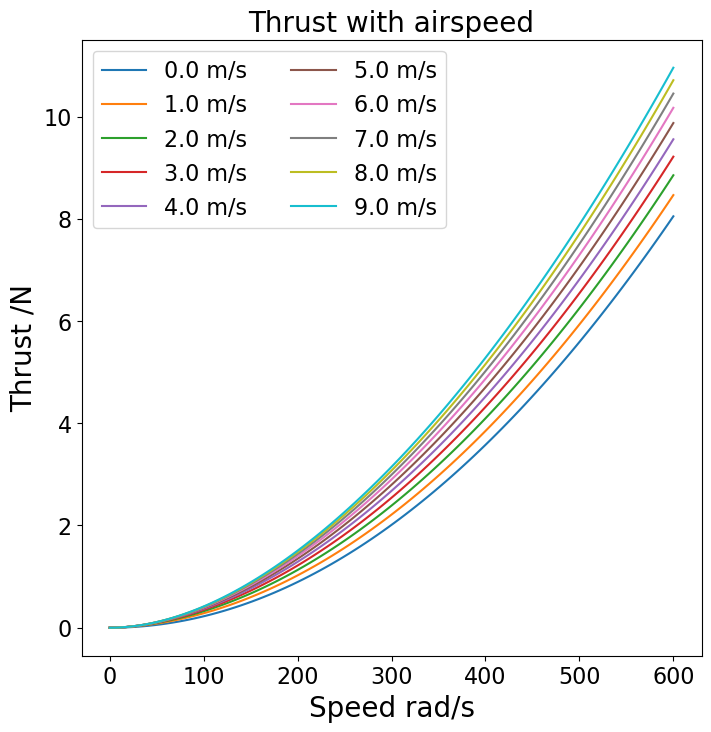

In [35]:
%matplotlib inline
# Plot propeller speed by numerically solving the thrust equation,
# *if* accurate propeller measurements are given in params
pp_ = deepcopy(pp)
pp_.use_thrust_constant = False # Set to true to just use k_thrust
prop = Propeller(pp_, sp)
plt.figure(figsize=(8,8))
speeds = np.linspace(0, 600, num=100)
for a in np.linspace(0, 10, 10, endpoint=False):
    thrusts = []
    for s in speeds:
        thrusts.append(prop.thrust(s, np.asarray([0, 0, a])))
    plt.plot(speeds, thrusts, label='%.1f m/s' % a)
plt.xlabel('Speed rad/s')
plt.ylabel('Thrust /N')
plt.title('Thrust with airspeed')
plt.legend(ncol=2)

#### Vehicle

Create a `Multirotor` object, given `VehicleParams` and `SimulationParams`

bytecode dump:
>          0	NOP(arg=None, lineno=52)
           2	RESUME(arg=0, lineno=52)
           4	LOAD_GLOBAL(arg=1, lineno=59)
          16	LOAD_ATTR(arg=1, lineno=59)
          26	LOAD_FAST(arg=0, lineno=59)
          28	PRECALL(arg=1, lineno=59)
          32	CALL(arg=1, lineno=59)
          42	STORE_FAST(arg=3, lineno=59)
          44	LOAD_FAST(arg=1, lineno=60)
          46	STORE_FAST(arg=4, lineno=60)
          48	LOAD_FAST(arg=4, lineno=61)
          50	LOAD_CONST(arg=1, lineno=61)
          52	BINARY_SUBSCR(arg=None, lineno=61)
          62	LOAD_FAST(arg=2, lineno=61)
          64	LOAD_CONST(arg=2, lineno=61)
          66	BINARY_SUBSCR(arg=None, lineno=61)
          76	LOAD_FAST(arg=0, lineno=61)
          78	LOAD_CONST(arg=2, lineno=61)
          80	BINARY_SUBSCR(arg=None, lineno=61)
          90	BINARY_OP(arg=5, lineno=61)
          94	BINARY_OP(arg=10, lineno=61)
          98	LOAD_FAST(arg=3, lineno=61)
         100	LOAD_CONST(arg=1, lineno=61)
         102	STORE_SUBSCR

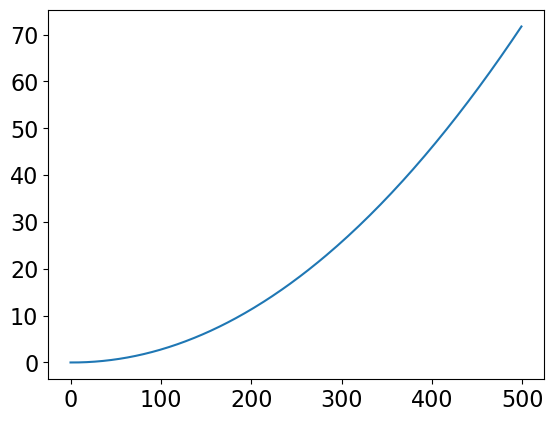

In [8]:
# Combine propeller/motor/vehicle to get vehicle.
# Take off simulation
m = Multirotor(vp, sp)
log = DataLog(vehicle=m) # convenient logging class
m.reset()
m.state *= 0 # set to zero, reset() sets random values
action = m.allocate_control( # In this case action is allocated speed signals
    thrust=m.weight * 1.1,
    torques=np.asarray([0, 0, 0])
)
for i in range(500):
    m.step_speeds(action)
    log.log()
log.done_logging()
plt.plot(log.z)

### Gym Environment

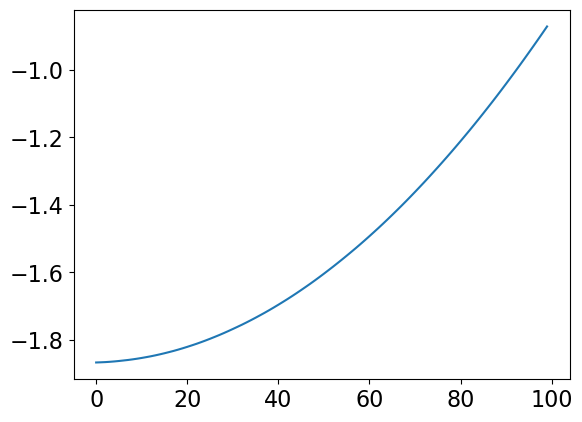

In [9]:
# this env takes the vector of [force_x, force_y, force_z, torque_x, torque_y, torque_z] to move
# the multirotor
env = DynamicsMultirotorEnv(Multirotor(vp, sp), max_rads=600)
env.reset()
log = DataLog(vehicle=env.vehicle)
for _ in range(100):
    env.step(np.asarray([0,0,env.vehicle.weight * 1.2, 0,0,0]))
    log.log()
log.done_logging()
plt.plot(log.z)

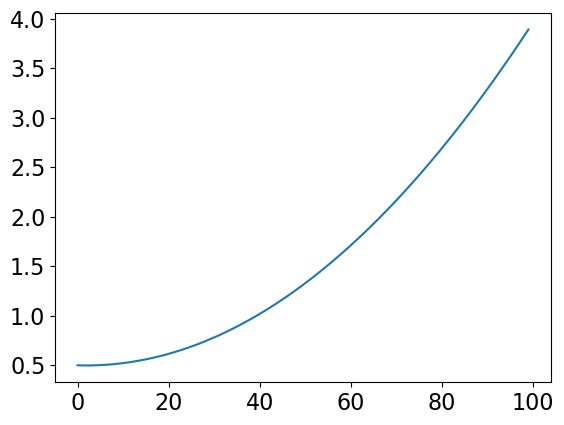

In [10]:
# this env takes the vector of speed signals to move
# the multirotor
env = SpeedsMultirotorEnv(Multirotor(vp, sp))
env.reset()
log = DataLog(vehicle=env.vehicle)
for _ in range(100):
    env.step(np.ones(8) * 400)
    log.log()
log.done_logging()
plt.plot(log.z)

### PID Controller

This section explains how a PID controller is constructed. This is a cascaded PID architecture. See `Controller` docs
for more details.

In [11]:
# From PID parameters file
def get_controller(m: Multirotor, max_velocity=5., max_acceleration=3.):
    assert m.simulation.dt <= 0.1, 'Simulation time step too large.'
    pos = PosController(
        1.0, 0., 0., 1., vehicle=m,
        max_velocity=max_velocity, max_acceleration=max_acceleration,
        square_root_scaling=False, leashing=False
    )
    vel = VelController(
        2.0, 1.0, 0.5,
        max_err_i=max_acceleration,
        max_tilt=np.pi/12,
        vehicle=m)
    att = AttController(
        [2.6875, 4.5, 4.5],
        0, 0.,
        max_err_i=1.,
        vehicle=m)
    rat = RateController(
        [4., 4., 4.],
        0, 0,
        max_err_i=0.5,
        max_acceleration=1.,
        vehicle=m)
    alt = AltController(
        1, 0, 0,
        max_err_i=1, vehicle=m,
        max_velocity=max_velocity)
    alt_rate = AltRateController(
        5, 0, 0,
        max_err_i=1, vehicle=m)
    ctrl = Controller(
        pos, vel, att, rat, alt, alt_rate,
        period_p=0.1, period_a=0.01, period_z=0.1
    )
    return ctrl

Loaded backend module://matplotlib_inline.backend_inline version unknown.
bytecode dump:
>          0	NOP(arg=None, lineno=35)
           2	RESUME(arg=0, lineno=35)
           4	LOAD_GLOBAL(arg=1, lineno=37)
          16	LOAD_FAST(arg=0, lineno=37)
          18	PRECALL(arg=1, lineno=37)
          22	CALL(arg=1, lineno=37)
          32	STORE_FAST(arg=3, lineno=37)
          34	LOAD_GLOBAL(arg=3, lineno=38)
          46	LOAD_FAST(arg=0, lineno=38)
          48	PRECALL(arg=1, lineno=38)
          52	CALL(arg=1, lineno=38)
          62	STORE_FAST(arg=4, lineno=38)
          64	LOAD_GLOBAL(arg=1, lineno=39)
          76	LOAD_FAST(arg=1, lineno=39)
          78	PRECALL(arg=1, lineno=39)
          82	CALL(arg=1, lineno=39)
          92	STORE_FAST(arg=5, lineno=39)
          94	LOAD_GLOBAL(arg=3, lineno=40)
         106	LOAD_FAST(arg=1, lineno=40)
         108	PRECALL(arg=1, lineno=40)
         112	CALL(arg=1, lineno=40)
         122	STORE_FAST(arg=6, lineno=40)
         124	LOAD_GLOBAL(arg=1,

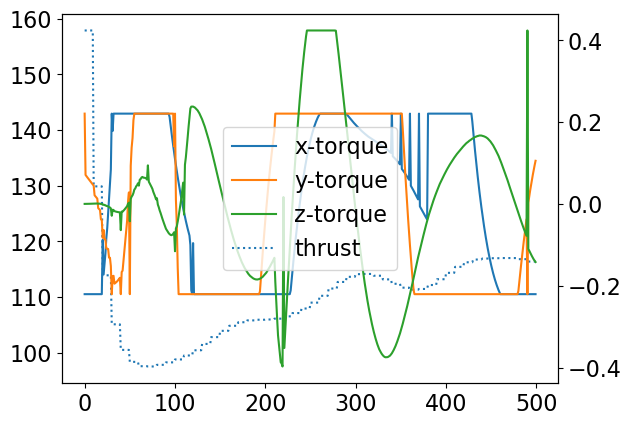

In [12]:
%matplotlib inline
m = Multirotor(vp, sp)
ctrl = get_controller(m)
log = DataLog(vehicle=m, controller=ctrl)
for i in range(500):
    action = ctrl.step((0.01,0.1,1,0))
    # no allocation or motor simulation, for which we first need to
    # m.step_speeds(m.allocate_control(action[0], action[3:])
    # Instead, requested dynamics are fulfilled:
    dynamics = np.zeros(6, m.dtype)
    dynamics[2] = action[0]
    dynamics[3:] = action[1:]
    m.step_dynamics(dynamics)
    log.log()
log.done_logging()

plt.plot(log.actions[:,0], ls=':', label='thrust')
lines = plt.gca().lines
plt.twinx()
for s, axis in zip(log.actions.T[1:], ('x','y','z')):
    plt.plot(s, label=axis + '-torque')
plt.legend(handles=plt.gca().lines + lines)

#### Attitude Angle Controller

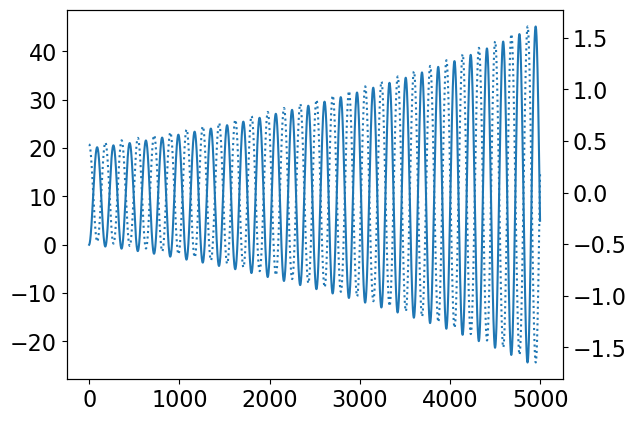

In [13]:
m = Multirotor(vp, sp)
fz = m.weight
ctrl = get_controller(m)
att =  ctrl.ctrl_a
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(5000):
    ref = np.asarray([np.pi/18, 0, 0])
    # action is prescribed euler rate
    action = att.step(ref, m.orientation, dt=sp.dt)
    # action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=att.err_p[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi)
plt.twinx()
plt.plot(log.actions[:,0], ls=':', label='Rate rad/s')

#### Attitude Rate Controller

Text(0.5, 1.0, 'Ref orientation[0.175 0.262 0.000]')

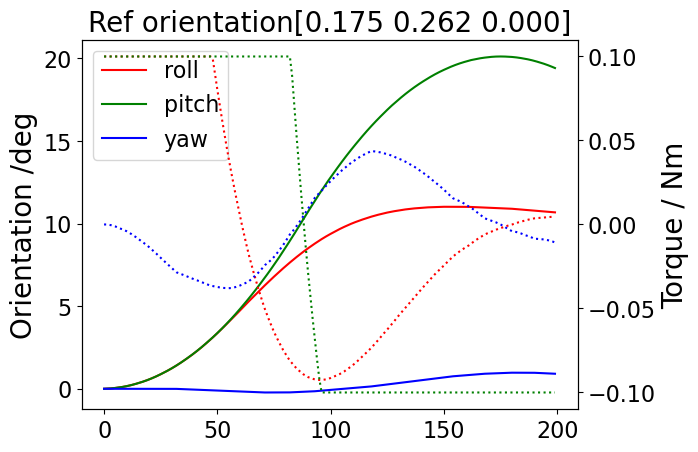

In [14]:
m = Multirotor(vp, sp)
fz = m.weight
ctrl = get_controller(m)
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(200):
    ref = np.asarray([np.pi/18, np.pi/12, 0])
    rate = att.step(ref, m.orientation, m.simulation.dt)
    torque = rat.step(rate, m.euler_rate, m.simulation.dt)
    action = np.clip(torque, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=rat.err_p[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi, c='r', label='roll')
plt.plot(log.pitch * 180 / np.pi, c='g', label='pitch')
plt.plot(log.yaw * 180 / np.pi, c='b', label='yaw')
plt.ylabel('Orientation /deg')
plt.legend()
plt.twinx()
plt.plot(log.actions[:,0], ls=':', c='r')
plt.plot(log.actions[:,1], ls=':', c='g')
plt.plot(log.actions[:,2], ls=':', c='b')
plt.ylabel('Torque / Nm')
plt.title('Ref orientation' + str(ref))

#### Altitude Controller

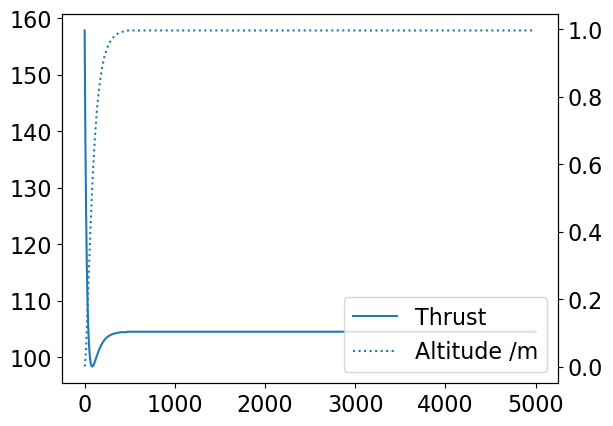

In [15]:
m = Multirotor(vp, sp)
ctrl = get_controller(m)
alt = ctrl.ctrl_z
alt_rate = ctrl.ctrl_vz
log = DataLog(vehicle=m, other_vars=('thrust',))
for i in range(5000):
    ref = np.asarray([1.])
    rate = alt.step(ref, m.position[2:], dt=0.1)
    action = alt_rate.step(rate, m.inertial_velocity[2:], dt=0.1)
    action = np.clip(action, a_min=-2*m.weight, a_max=2*m.weight)
    m.step_dynamics(np.asarray([0, 0, action[0], 0,0,0]))
    log.log(thrust=action)
    #log._actions[-1] = action
log.done_logging()

l = plt.plot(log.thrust.squeeze(), label='Thrust')
plt.twinx()
plt.plot(log.z, ls=':', label='Altitude /m')
plt.legend(handles=l+plt.gca().lines)

#### Position Controller

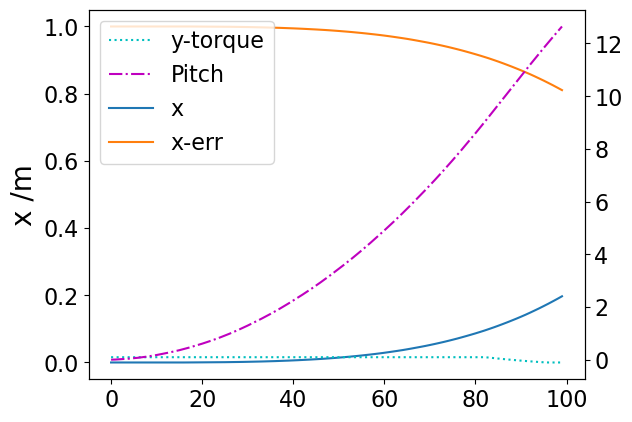

In [16]:
m = Multirotor(vp, sp)
ctrl = get_controller(m)
pos = ctrl.ctrl_p
vel = ctrl.ctrl_v
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, other_vars=('err', 'torques'))
for i in range(100):
    ref = np.asarray([1.,0.])
    
    # converting position -> velocity -> angles
    velocity = pos.step(ref, m.position[:2], dt=0.1)
    angles = vel.step(velocity, m.velocity[:2], dt=0.1)[::-1]
    # attitude controller operates at higher frequency
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    # clipping torques to prevent over-reactions
    action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    log.log(err=pos.err[0], torques=action)
log.done_logging()

plt.plot(log.x, label='x')
plt.plot(log.err, label='x-err')
plt.ylabel('x /m')
l = plt.gca().lines
plt.twinx()
plt.plot(log.torques[:,1], ls=':', label='y-torque', c='c')
plt.plot(log.pitch * 180 / np.pi, ls='-.', label='Pitch', c='m')
plt.legend(handles=plt.gca().lines+l)
# plt.plot(log.actions[:,0] * 180 / np.pi, ls=':')

### Parameter search

Using `optuna` to search over the space of PID controller parameters.

In [17]:
# from multirotor.optimize import optimize, DEFAULTS
# print(DEFAULTS)

In [18]:
# search over parameter space
# study = optimize(vp, sp, ntrials=100)

In [19]:
# # apply best parameters from study to controller, and run a simulation
# from multirotor.optimize import run_sim, apply_params

# env = DynamicsMultirotorEnv(Multirotor(vp, sp))
# traj = Trajectory(env.vehicle, [[0,0,0]], proximity=1)
# ctrl = get_controller(env.vehicle)
# ctrl.set_params(**apply_params(None, params=study.best_params))

# env.reset()
# ctrl.reset()
# log = run_sim(env, traj, ctrl)
# plot_datalog(log)

### Simulation

Combining `Multiotor` and `Controller` to run a simulation. First, defining waypoints:

In [20]:
# NASA flight test
# wp = np.asarray([
#     [0.0, 0.0, 30.0],
#     [164.0146725649829, -0.019177722744643688, 30.0],
#     [165.6418055187678, 111.5351051245816, 30.0],
#     [127.3337449710234, 165.73576059611514, 30.0],
#     [-187.28170707810204, 170.33217775914818, 45.0],
#     [-192.03130502498243, 106.30660058604553, 45.0],
#     [115.89920266153058, 100.8644210617058, 30.0],
#     [114.81859536317643, 26.80923518165946, 30.0],
#     [-21.459931490011513, 32.60508110653609, 30.0]
# ])
wp = np.asarray([
    [0,10,0],
    [10,10,0],
    [10,0,0],
    [0,0,0]
])

Then, defining a disturbance (for example, wind). The disturabance function takes time, `Multirotor`, and returns the forces in the *body frame* of the vehicle.

In [21]:
def wind(t, m):
    w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
    dcm = direction_cosine_matrix(*m.orientation)
    return inertial_to_body(w_inertial, dcm)

In [22]:
# Defining the run simulation function which illustrates all the
# steps that go into each step of the simulation.
# 
def run_sim(env, traj, ctrl, steps=60_000, disturbance=None):

    log = DataLog(env.vehicle, ctrl,
                  other_vars=('currents', 'voltages'))

    disturb_force, disturb_torque = 0., 0
    for i, (pos, feed_forward_vel) in tqdm(
        enumerate(traj), leave=False, total=steps
    ):
        if i==steps: break
        # Generate reference for controller
        ref = np.asarray([*pos, 0.])
        # Get prescribed dynamics for system as thrust and torques
        dynamics = ctrl.step(ref, feed_forward_velocity=feed_forward_vel)
        thrust, torques = dynamics[0], dynamics[1:]
        # Allocate control: Convert dynamics into motor rad/s
        action = env.vehicle.allocate_control(thrust, torques)
        # get any disturbances
        if disturbance is not None:
            disturb_force, disturb_torque = disturbance(i, env.vehicle)
        # Send speeds to environment
        state, *_ = env.step(
            action, disturb_forces=disturb_force, disturb_torques=disturb_torque
        )
        alloc_errs = np.asarray([thrust, *torques]) - env.vehicle.alloc @ action**2

        print(log._args)
        print([p.motor.current for p in env.vehicle.propellers])
        print(type([p.motor.current for p in env.vehicle.propellers]))
        log.log(currents=[p.motor.current for p in env.vehicle.propellers],
                voltages=[p.motor.voltage for p in env.vehicle.propellers])

        if np.any(np.abs(env.vehicle.orientation[:2]) > np.pi/6): break

    log.done_logging()
    return log

In [23]:
env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
traj = Trajectory(env.vehicle, wp, proximity=2, resolution=10)
ctrl = get_controller(env.vehicle, max_velocity=3.)
env.reset()
ctrl.reset()
log = run_sim(env, traj, ctrl, steps=60_000, disturbance=None)

  0%|          | 11/60000 [00:00<09:22, 106.65it/s]

('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[15.363339272292873,
 15.363339272292873,
 15.613257069027103,
 15.966265071396643,
 16.21557701902431,
 16.21557701902431,
 15.966265071396643,
 15.613257069027103]
<class 'list'>
('currents', 'voltages')
[23.28196101791153,
 23.291946926877014,
 23.31521128518784,
 23.37213882953179,
 23.395346790558627,
 23.405298481705646,
 23.362177152662383,
 23.325187135455348]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0,

  0%|          | 22/60000 [00:00<10:27, 95.61it/s] 

('currents', 'voltages')
[27.729127697991366,
 28.45461180335074,
 27.843843986895912,
 28.73016835986575,
 28.120701423083833,
 28.84428467716846,
 28.00603830759873,
 28.568761338048727]
<class 'list'>
('currents', 'voltages')
[3.980198134862995,
 4.06245143316077,
 3.9880373868006935,
 4.088723680637606,
 4.009627635847333,
 4.100666233129751,
 4.000229598090529,
 4.072892670051279]
<class 'list'>
('currents', 'voltages')
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'list'>
('currents', 'voltages')
[19.78738738431295,
 20.82668111546643,
 19.927255906952862,
 21.15437622864128,
 20.261893333023785,
 21.28889070302624,
 20.12380186947924,
 20.962923446864217]
<class 'list'>
('currents', 'voltages')
[25.829673602588546,
 26.83629852773287,
 25.958131708359517,
 27.143647000653974,
 26.267956228235164,
 27.27085143110933,
 26.139673469937055,
 26.963650069879876]
<class 'list'>
('currents', 'voltages')
[4.99877401413739,
 4.877393628758124,
 4.974678397197861,
 4.82572777890979,
 4.

  0%|          | 43/60000 [00:00<13:48, 72.34it/s]

('currents', 'voltages')
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'list'>
('currents', 'voltages')
[14.216426154774961,
 16.99402944782821,
 14.472835509333128,
 17.584454078593975,
 15.088535713878894,
 17.8279637907224,
 14.834062796440506,
 17.239037210683218]
<class 'list'>
('currents', 'voltages')
[17.059924955302144,
 18.29204264137918,
 17.109380325166708,
 18.49767873411068,
 17.356625220812436,
 18.633197321817335,
 17.307087715227027,
 18.428138839554308]
<class 'list'>
('currents', 'voltages')
[2.591959364621036,
 1.0123885727876025,
 2.350732010936042,
 0.6146710325341743,
 1.9946576654212103,
 0.5388727155251538,
 2.2333760976409325,
 0.9356070994260273]
<class 'list'>
('currents', 'voltages')
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'list'>
('currents', 'voltages')
[13.525386828425361,
 16.94552579272016,
 13.783597313714289,
 17.593116362273815,
 14.45875838060902,
 17.883227446621557,
 14.201037587477465,
 17.23547333481588]
<class 'list'>
('currents', 'vo

  0%|          | 76/60000 [00:00<11:43, 85.22it/s]

('currents', 'voltages')
[11.23036743955755,
 10.839482334141337,
 11.163020819560494,
 10.220027741403939,
 11.019070321249764,
 9.949374620355492,
 11.107015568691565,
 10.57316245375018]
<class 'list'>
('currents', 'voltages')
[2.154485731338235,
 0.11997974604501709,
 2.0346132988542074,
 0.08997150281622975,
 2.3970248264686576,
 0.05173447796827894,
 2.179068860799068,
 0.07980709947431046]
<class 'list'>
('currents', 'voltages')
[1.9063255727394308,
 2.9386362360843497,
 1.9416118353699654,
 3.41653396563474,
 1.9359365474238144,
 3.5951908131935704,
 1.8752764608584471,
 3.113320761347292]
<class 'list'>
('currents', 'voltages')
[10.829515803705373,
 13.548938608608882,
 10.90756198927868,
 13.414609634192086,
 10.349575003567475,
 13.342775178888953,
 10.603685723726507,
 13.479136817934869]
<class 'list'>
('currents', 'voltages')
[11.404645767395024,
 10.82855538193281,
 11.328427910567864,
 10.171483993585635,
 11.103186188483276,
 9.872469006025137,
 11.21295599354017,
 10.

  0%|          | 107/60000 [00:01<12:32, 79.59it/s]

('currents', 'voltages')
[13.208738267469045,
 12.173743348184496,
 13.165235300113212,
 11.926218828860483,
 12.707712649449673,
 11.677935453770676,
 12.77692657778448,
 11.956465740376116]
<class 'list'>
('currents', 'voltages')
[7.92792065476954,
 2.3334160757143136,
 7.721938450478217,
 1.875515289487814,
 8.01349270669248,
 1.8373241385294392,
 8.022419959606932,
 2.2699549782870547]
<class 'list'>
('currents', 'voltages')
[2.151009495863484,
 1.8625386508635209,
 2.164408257702207,
 1.9445362032348672,
 2.4309086449206476,
 2.0712791712154943,
 2.390116505413431,
 1.958863584553766]
<class 'list'>
('currents', 'voltages')
[7.20258984230797,
 11.678930838955903,
 7.38407443854763,
 11.960805355160849,
 6.880233600152669,
 11.859779785374446,
 6.893356832872158,
 11.602546561453018]
<class 'list'>
('currents', 'voltages')
[17.327845232317543,
 16.59698731902344,
 17.287690326526654,
 16.372157810753613,
 16.823986255930492,
 16.134582172456167,
 16.89332254957561,
 16.389265496312

  0%|          | 116/60000 [00:01<13:12, 75.60it/s]

('currents', 'voltages')
[14.39290367838082,
 0.0,
 14.149348011765213,
 0.0,
 14.272017468885176,
 0.0,
 14.607808791212802,
 0.0]
<class 'list'>
('currents', 'voltages')
[21.294380181675116,
 0.0,
 21.156385356041234,
 0.0,
 21.26405608215491,
 0.0,
 21.385177350517736,
 0.0]
<class 'list'>
('currents', 'voltages')
[7.123594331371838,
 2.8132359423531788,
 7.390945343333158,
 2.2875687327823333,
 7.041826121593299,
 2.186906170835246,
 6.6827412952039476,
 2.7165609475009056]
<class 'list'>
('currents', 'voltages')
[0.8883971656622208,
 12.496431787910733,
 1.0510909329602627,
 12.377029970471298,
 0.7144759413040105,
 12.147796607806631,
 0.5700588221158153,
 12.267639079289427]
<class 'list'>
('currents', 'voltages')
[14.831793755732138,
 7.966600222107278,
 14.59000951276625,
 8.326881893280765,
 14.69482121895607,
 8.21697517177873,
 15.029023200769025,
 7.853529763115348]
<class 'list'>
('currents', 'voltages')
[21.077538721216804,
 0.0,
 20.94569215747476,
 0.0,
 21.03826227661

  0%|          | 146/60000 [00:01<12:21, 80.76it/s]

('currents', 'voltages')
[21.468684388037165,
 8.502646475715768,
 21.52994347928777,
 8.660016017841297,
 21.288837769314068,
 8.738209085709759,
 21.224653309780507,
 8.578364231001505]
<class 'list'>
('currents', 'voltages')
[6.399845062151196,
 4.067152835024558,
 6.533418083101002,
 3.685527723215879,
 6.568874209309818,
 3.6728681226650095,
 6.3049003158864565,
 4.051049515589335]
<class 'list'>
('currents', 'voltages')
[0.0,
 7.314121234014025,
 0.0,
 7.0418977651432995,
 0.0,
 6.781012153284288,
 0.0,
 7.055268473132255]
<class 'list'>
('currents', 'voltages')
[12.273610667852708,
 11.411247438505221,
 12.200449795224923,
 11.667308193821887,
 11.906743255659347,
 11.477593487850223,
 12.116389538715996,
 11.225374172878087]
<class 'list'>
('currents', 'voltages')
[19.87580047543692,
 8.398065121419139,
 19.9437887950653,
 8.559500543585296,
 19.694729809544796,
 8.617094385690745,
 19.625071505785915,
 8.453706151408614]
<class 'list'>
('currents', 'voltages')
[6.5051079251259

  0%|          | 163/60000 [00:02<13:40, 72.91it/s]

('currents', 'voltages')
[13.464867775228461,
 5.455687729205254,
 13.58482339245593,
 5.053420302148925,
 13.657071554658506,
 5.085775385043457,
 13.407695839289554,
 5.479467745216236]
<class 'list'>
('currents', 'voltages')
[0.0,
 11.35238738832366,
 0.0,
 11.01057286754919,
 0.0,
 10.743526276591743,
 0.0,
 11.086877830985014]
<class 'list'>
('currents', 'voltages')
[0.0014598107220600808,
 16.26691274853361,
 0.0,
 16.54052346050717,
 0.0,
 16.308052483633983,
 0.0,
 16.04367647394998]
<class 'list'>
('currents', 'voltages')
[14.247620109116571,
 9.857290979965002,
 14.219986728697378,
 10.060704064885618,
 13.687214109561898,
 10.137508591253676,
 13.82424064684875,
 9.932734810606565]
<class 'list'>
('currents', 'voltages')
[14.621301387580445,
 4.804421860779097,
 14.656089040047002,
 4.37310140074928,
 14.431086083240316,
 4.414833084269172,
 14.384726061991856,
 4.836647075768207]
<class 'list'>
('currents', 'voltages')
[0.0,
 11.917472458450002,
 0.0,
 11.571075369226072,
 

  0%|          | 179/60000 [00:02<14:29, 68.82it/s]

('currents', 'voltages')
[12.331377118096748,
 8.738716643106681,
 12.442867217271447,
 9.017673530014717,
 12.168058749307257,
 9.265067830681167,
 12.257089224717058,
 8.983657585450622]
<class 'list'>
('currents', 'voltages')
[15.111247959800487,
 2.0489542303922037,
 15.040223608448999,
 1.5709012848523964,
 14.988033301256916,
 1.8237703717970768,
 15.064791099056755,
 2.28833252980546]
<class 'list'>
('currents', 'voltages')
[2.016620864954563,
 12.733030892853996,
 1.8401168495457354,
 12.384672400821469,
 2.0996039745167745,
 12.125201468299272,
 2.080305390172834,
 12.475654229402894]
<class 'list'>
('currents', 'voltages')
[0.0,
 19.68577418112082,
 0.0,
 20.140509663216054,
 0.0,
 19.91831923823025,
 0.0,
 19.477260197144787]
<class 'list'>
('currents', 'voltages')
[11.695863526649411,
 8.096891622343753,
 11.78792062184684,
 8.426703347511678,
 11.678485291563256,
 8.773694474236608,
 11.774202547632093,
 8.441678627978046]
<class 'list'>
('currents', 'voltages')
[15.367467

  0%|          | 210/60000 [00:02<11:21, 87.69it/s]

('currents', 'voltages')
[16.995953635176313,
 0.0,
 16.88355436963195,
 0.0,
 17.099286554303774,
 0.0,
 17.21382203437443,
 0.0]
<class 'list'>
('currents', 'voltages')
[7.290395227179192,
 9.862318080435312,
 6.917851193698298,
 8.717252405249498,
 6.798613707038737,
 8.970026539811803,
 7.017508209686875,
 10.10990294692036]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.191112100626338,
 0.0,
 20.280117744967953,
 0.0,
 20.518625628224303,
 0.0,
 20.4286601423578]
<class 'list'>
('currents', 'voltages')
[8.515482826490794,
 9.397236202281139,
 8.823174387397403,
 10.664447082346769,
 9.18316521305056,
 10.615684202713528,
 9.025775729960978,
 9.353367407939155]
<class 'list'>
('currents', 'voltages')
[17.42387588556582,
 0.0,
 17.32065423284903,
 0.0,
 17.54231296962995,
 0.0,
 17.647085086938816,
 0.0]
<class 'list'>
('currents', 'voltages')
[8.463477395813314,
 8.510959045187878,
 8.016703745840484,
 7.269600346319973,
 7.851745131426139,
 7.559812582062509,
 8.14891060501067

  0%|          | 239/60000 [00:03<12:10, 81.78it/s]

('currents', 'voltages')
[13.747990235955985,
 3.023611217927481,
 13.290002610505159,
 5.2292636373329735,
 13.360319759123541,
 4.884392176893611,
 13.802674469629988,
 2.9463457437641094]
<class 'list'>
('currents', 'voltages')
[6.744865799168862,
 24.026158353531574,
 6.292404797001131,
 23.959597025455697,
 5.849997587008763,
 23.944196490437914,
 6.203043263958007,
 23.708100301316822]
<class 'list'>
('currents', 'voltages')
[0.034331429047229085,
 21.48469888513367,
 0.16527187873499125,
 19.084910424064372,
 0.21652596558464893,
 19.745826057433018,
 0.09919635417184647,
 21.8755193070951]
<class 'list'>
('currents', 'voltages')
[6.797888961119953,
 0.08071607186100879,
 6.91551973606111,
 0.05828961132590428,
 7.486770179987007,
 0.35402159266287414,
 7.467298305580646,
 0.6840902888377535]
<class 'list'>
('currents', 'voltages')
[13.5093424203306,
 3.14830481805909,
 13.054308770431174,
 5.448083918484037,
 13.1499160303886,
 5.083819195926987,
 13.592340086624665,
 3.0448897

  0%|          | 274/60000 [00:03<09:58, 99.86it/s]

('currents', 'voltages')
[11.950023446873898,
 9.404529588340623,
 11.59861303709845,
 10.149934699048815,
 11.156413026156997,
 10.629859627692525,
 11.404156514248365,
 9.68361576260619]
<class 'list'>
('currents', 'voltages')
[6.401481979218188,
 15.581006062768582,
 6.623626068231084,
 15.456364497413768,
 6.60995162137744,
 15.790065228446933,
 6.4030707325575555,
 15.91326058583059]
<class 'list'>
('currents', 'voltages')
[13.622411749775344,
 4.398413344796407,
 13.665346083371771,
 3.528255861837429,
 14.24507000773898,
 3.379819066495381,
 14.307999500307954,
 4.448412242105217]
<class 'list'>
('currents', 'voltages')
[19.779131715654646,
 0.0,
 19.243786742699676,
 0.0,
 19.372632886095857,
 0.0,
 19.88961872983858,
 0.0]
<class 'list'>
('currents', 'voltages')
[11.594593981875986,
 7.489899561680396,
 11.298709428861036,
 8.242336292885188,
 10.844588526687899,
 8.715085561874679,
 11.03180580453318,
 7.765839873437683]
<class 'list'>
('currents', 'voltages')
[5.340257009012

  0%|          | 298/60000 [00:03<10:46, 92.33it/s] 

('currents', 'voltages')
[2.9332830650572568,
 11.854259603669428,
 3.7481344997829376,
 12.322503287780275,
 4.051602437225339,
 12.506270039806413,
 3.296032282089469,
 12.025117809638479]
<class 'list'>
('currents', 'voltages')
[16.215901972371086,
 7.851782773717113,
 16.1989325929521,
 7.281338656821447,
 17.07078163895896,
 7.096744140854176,
 17.22428634667999,
 7.837982980912588]
<class 'list'>
('currents', 'voltages')
[21.98046739484828,
 1.9793109904929047,
 21.177790008372376,
 1.726575053317865,
 21.12549586684376,
 1.710377427179684,
 21.865045588421577,
 1.978212127097917]
<class 'list'>
('currents', 'voltages')
[8.242382323438932,
 5.798263302595241,
 8.341278979480368,
 6.6313945556973195,
 7.728809942752695,
 6.967699723419425,
 7.491122645589357,
 5.965898192148077]
<class 'list'>
('currents', 'voltages')
[2.640592174408442,
 11.625153280296189,
 3.5507492542381254,
 12.201111499336026,
 3.9156527180275917,
 12.36253941036113,
 3.072967179188997,
 11.769648482669842]


  1%|          | 321/60000 [00:03<10:09, 97.87it/s]

('currents', 'voltages')
[0.0,
 10.398874043505138,
 0.12929363372892477,
 11.655127486417062,
 0.941228636493906,
 11.630317209040609,
 0.0,
 10.337709486506586]
<class 'list'>
('currents', 'voltages')
[17.553380321191266,
 9.487094511561091,
 18.397801443238226,
 9.04433726632794,
 19.53190437996947,
 8.920951293619913,
 19.65548546684502,
 9.509524499797916]
<class 'list'>
('currents', 'voltages')
[21.800328927612462,
 5.918793059241426,
 21.50975323324072,
 4.904150340696288,
 20.965665571273433,
 5.0766335127420525,
 21.936688736778468,
 6.128877639773491]
<class 'list'>
('currents', 'voltages')
[2.594262664113942,
 7.752259003182822,
 1.840704302576987,
 8.446830447245095,
 0.9918020260531833,
 8.705908934518186,
 0.7693206852892841,
 7.866585962708122]
<class 'list'>
('currents', 'voltages')
[0.0,
 11.812849169291601,
 0.0,
 13.160908119080734,
 0.0,
 13.098882553793647,
 0.0,
 11.712446874682774]
<class 'list'>
('currents', 'voltages')
[15.944253886210353,
 9.684967663781974,
 

  1%|          | 345/60000 [00:04<09:13, 107.71it/s]

('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0,
 33.650523123738786,
 37.18302685237169,
 32.81173121716971,
 35.187618340784574,
 32.96791717995806,
 36.49563136783877,
 33.70400299232621]
<class 'list'>
('currents', 'voltages')
[0.0,
 7.689171139676851,
 0.0,
 8.053817946884175,
 0.0,
 7.7279268893738635,
 0.0,
 7.396161599367392]
<class 'list'>
('currents', 'voltages')
[10.2494695984916,
 22.74931380305565,
 11.58708827037243,
 23.8415337466454,
 13.90331936164272,
 23.36439118797954,
 11.680998097603405,
 22.380162252980302]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
<class 'list'>
('currents', 'voltages')
[13.359467866018303,
 14.68804674671995,
 12.757778261672087,
 13.769718258610654,
 10.27890378921563,
 13.733958360139447,
 11.781974792843457,
 14.540880816955724]
<class '

  1%|          | 367/60000 [00:04<10:17, 96.51it/s] 

('currents', 'voltages')
[0.5817288930416304,
 0.0,
 0.5368760628967464,
 0.0,
 0.5367908734544585,
 0.0,
 0.5725681402260643,
 0.0]
<class 'list'>
('currents', 'voltages')
[4.79285264805902,
 24.33730355622064,
 5.110687867689409,
 24.536890195749187,
 3.498160470624976,
 24.445679358725155,
 1.7838815419786378,
 24.262614374038073]
<class 'list'>
('currents', 'voltages')
[1.0379041272275615,
 12.546222697372812,
 0.3072459617003728,
 11.688204220726478,
 0.0,
 11.615386272896233,
 0.30515495375608664,
 12.473172579947391]
<class 'list'>
('currents', 'voltages')
[10.630758578764615,
 0.0,
 11.753652248920112,
 0.0,
 13.32194790737227,
 0.0,
 13.974075309604544,
 0.0]
<class 'list'>
('currents', 'voltages')
[13.175820190738051,
 5.6897000205157955,
 14.076508200468847,
 7.218782474072511,
 14.27848628197355,
 6.541879764933695,
 13.791977702770499,
 4.993723887541175]
<class 'list'>
('currents', 'voltages')
[3.01011136746138,
 21.431314902018773,
 2.2356188602166203,
 21.42280272330081

  1%|          | 387/60000 [00:04<11:17, 88.05it/s]

('currents', 'voltages')
[14.345525878285875,
 1.4938466060580038,
 15.233476154483139,
 1.7537630529116908,
 16.290960644749855,
 1.5161845513247751,
 14.996224099925017,
 1.8048116255306617]
<class 'list'>
('currents', 'voltages')
[12.400819089756727,
 0.0,
 12.992697478753216,
 0.0,
 12.999563961995229,
 0.0,
 13.64910088889251,
 0.0]
<class 'list'>
('currents', 'voltages')
[1.1333610191070191,
 13.43055648267942,
 0.5687378566178414,
 14.568239319677172,
 0.0,
 13.940795085321273,
 0.393079467794504,
 12.24291722787272]
<class 'list'>
('currents', 'voltages')
[2.9970050713110212,
 17.35702732942801,
 2.731997400555807,
 17.295235736002528,
 2.0802379792663914,
 17.053784525486652,
 1.6356216006772473,
 17.108835791230653]
<class 'list'>
('currents', 'voltages')
[15.073432732603411,
 2.7878474743481703,
 15.959428356709571,
 1.7865607162255488,
 16.46959051023601,
 2.1002388274422525,
 15.671520630159037,
 3.6548813447474293]
<class 'list'>
('currents', 'voltages')
[13.5144977217203

  1%|          | 422/60000 [00:04<09:59, 99.46it/s] 

('currents', 'voltages')
[19.108105113239706,
 5.250758274917207,
 19.15307089408278,
 4.141219542613776,
 19.39215776969609,
 4.643934112748627,
 18.146426674286413,
 6.14623997069181]
<class 'list'>
('currents', 'voltages')
[21.922752684539066,
 1.1263055602013348,
 22.195082619884317,
 0.9784679622697248,
 21.950493946378916,
 1.0619336229061518,
 21.75521716223052,
 1.2249340507224726]
<class 'list'>
('currents', 'voltages')
[0.03804713165061966,
 10.94979352555132,
 0.1964049405062406,
 12.093177870677923,
 0.0,
 11.304643482785993,
 0.835894446659412,
 9.775202461451778]
<class 'list'>
('currents', 'voltages')
[0.0,
 15.589208506897027,
 0.0,
 15.736146746714027,
 0.0,
 15.387692364455107,
 0.0,
 15.222233000351432]
<class 'list'>
('currents', 'voltages')
[18.259552549210586,
 4.91968035741272,
 18.159632239788248,
 3.7150750016771408,
 18.076719377488814,
 4.266943240088775,
 17.200622577712274,
 5.853758762981662]
<class 'list'>
('currents', 'voltages')
[20.868375721509125,
 0.

  1%|          | 444/60000 [00:05<10:33, 94.08it/s]

('currents', 'voltages')
[8.263915091148636,
 4.916761976028507,
 8.033033842104837,
 5.855198256026963,
 8.083038330925032,
 5.067236554058014,
 7.725367729205759,
 3.8318135882266984]
<class 'list'>
('currents', 'voltages')
[0.0,
 12.818086669882211,
 0.0,
 12.529577857742725,
 0.0,
 12.345720105288631,
 0.0,
 12.631291033624613]
<class 'list'>
('currents', 'voltages')
[13.883526716922916,
 8.95936002111494,
 14.065913042916925,
 7.711296832442682,
 13.71168589780803,
 8.354574839368842,
 14.264655135666251,
 9.897351532621839]
<class 'list'>
('currents', 'voltages')
[24.34631189532282,
 0.2631535193851613,
 24.236715546441886,
 0.23705659733473267,
 23.934111319293006,
 0.28485340158521005,
 24.00642697623177,
 0.3214811377586707]
<class 'list'>
('currents', 'voltages')
[9.182270684573062,
 4.6743085908880815,
 8.941009857734118,
 5.652414357145869,
 9.034036170767566,
 4.856331425594673,
 8.529373622887997,
 3.590695008749716]
<class 'list'>
('currents', 'voltages')
[0.0,
 12.90227

  1%|          | 479/60000 [00:05<09:27, 104.80it/s]

('currents', 'voltages')
[0.0,
 19.160751085155216,
 0.0,
 18.887653828388654,
 0.0,
 18.732942839075786,
 0.0,
 19.007319293795067]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.09774404660229,
 0.0,
 14.647714389291744,
 0.0,
 15.275755376073487,
 0.0,
 16.92996057268905]
<class 'list'>
('currents', 'voltages')
[16.315250545653313,
 0.0,
 16.288872688459204,
 0.0,
 16.227082639996816,
 0.0,
 15.86845066865835,
 0.0]
<class 'list'>
('currents', 'voltages')
[18.675497399686495,
 2.23787598288545,
 18.59807925302632,
 3.447180324779454,
 18.243438726132084,
 2.678693168974945,
 18.405915058832548,
 1.2691489317262714]
<class 'list'>
('currents', 'voltages')
[0.8004273798571553,
 20.065046249982988,
 0.7263798123171983,
 19.75873624605483,
 0.4898251605860547,
 19.615994935507942,
 0.9472444345071463,
 19.92512610189585]
<class 'list'>
('currents', 'voltages')
[0.0,
 17.906610284022975,
 0.0,
 16.385308571328927,
 0.0,
 17.036039834365837,
 0.0,
 18.760927124971364]
<class 'list'>
('

  1%|          | 503/60000 [00:05<09:10, 108.16it/s]

('currents', 'voltages')
[0.0,
 22.539797916024323,
 0.0,
 22.308900419902855,
 0.0,
 22.330443642256654,
 0.0,
 22.56326435318305]
<class 'list'>
('currents', 'voltages')
[9.83811886043848,
 0.0,
 9.498269665023363,
 0.0,
 9.72614350206159,
 0.0,
 9.664904443322907,
 0.0]
<class 'list'>
('currents', 'voltages')
[15.453741175669506,
 0.0,
 14.810273895041997,
 0.0,
 14.59465422986356,
 0.0,
 15.232906142272386,
 0.0]
<class 'list'>
('currents', 'voltages')
[4.1874114504034115,
 20.871909529567965,
 4.293308700512174,
 20.76160190163428,
 4.108379334157814,
 21.07804952744726,
 4.39591854022936,
 21.19387035903258]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.514812971444787,
 0.0,
 22.314906434668455,
 0.0,
 22.479163513013336,
 0.0,
 22.67616283162268]
<class 'list'>
('currents', 'voltages')
[8.956546887432966,
 0.20259307240357685,
 8.84394819802258,
 0.16706579418079026,
 9.337896792725939,
 0.07678335222512563,
 9.067199546342053,
 0.10590599510795635]
<class 'list'>
('current

  1%|          | 525/60000 [00:05<10:11, 97.19it/s] 

('currents', 'voltages')
[16.50087061163944,
 0.0,
 16.167844886152622,
 0.0,
 16.30004770582401,
 0.0,
 16.628556412477252,
 0.0]
<class 'list'>
('currents', 'voltages')
[7.2249966856112735,
 19.35690076115172,
 8.089868454823085,
 19.179150219929515,
 8.148946141255045,
 19.650208378838546,
 7.567055717708516,
 19.736858770486446]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.999352334626604,
 0.0,
 20.869591153372966,
 0.0,
 21.18289672055875,
 0.0,
 21.3127267599937]
<class 'list'>
('currents', 'voltages')
[8.310417778936925,
 0.3849923373407386,
 7.157486987357354,
 0.440326849809954,
 7.229565172134566,
 0.26449984375696173,
 8.10818986709921,
 0.29963450789327745]
<class 'list'>
('currents', 'voltages')
[16.91850433531144,
 0.0,
 16.587584030772025,
 0.0,
 16.719995601399464,
 0.0,
 17.0472582488416,
 0.0]
<class 'list'>
('currents', 'voltages')
[9.45924739675328,
 20.117365080352425,
 10.310404837885555,
 19.921168406059127,
 10.359887679092875,
 20.438693529705635,
 9.7800

  1%|          | 548/60000 [00:06<10:27, 94.72it/s]

('currents', 'voltages')
[19.774846083961457,
 0.0,
 19.454928276881304,
 0.0,
 19.589564037540896,
 0.0,
 19.910404712437828,
 0.0]
<class 'list'>
('currents', 'voltages')
[14.429216037163927,
 16.083266875688913,
 15.232180669224604,
 15.918282264950573,
 15.281166782759179,
 16.28484296245131,
 14.728951656735665,
 16.52202677902017]
<class 'list'>
('currents', 'voltages')
[0.0,
 19.41607543573683,
 0.0,
 19.284217155810612,
 0.0,
 19.602310659780848,
 0.0,
 19.73400790839039]
<class 'list'>
('currents', 'voltages')
[4.744667376120062,
 2.6563983899390378,
 3.643861605780456,
 2.697196729490979,
 3.7169347585067967,
 2.629979941793336,
 4.566663923462697,
 2.5166848647991062]
<class 'list'>
('currents', 'voltages')
[20.730728058519794,
 0.0,
 20.413923103646248,
 0.0,
 20.549838520400577,
 0.0,
 20.869218778354067,
 0.0]
<class 'list'>
('currents', 'voltages')
[15.283403570723094,
 14.942426164033055,
 16.090302748976598,
 14.759003374222697,
 16.14350330897616,
 15.169991107371263,

  1%|          | 573/60000 [00:06<09:24, 105.31it/s]

('currents', 'voltages')
[0.0,
 18.73543843328924,
 0.0,
 18.993154194559708,
 0.0,
 19.157323794803467,
 0.09098364565859096,
 18.89979211725292]
<class 'list'>
('currents', 'voltages')
[4.808188680846878,
 6.613578010930596,
 4.836296746908447,
 6.5513037178592635,
 4.759912129785125,
 6.419463722954893,
 4.799063166400286,
 6.40424825937277]
<class 'list'>
('currents', 'voltages')
[24.319531060252544,
 0.0,
 24.39602832243412,
 0.0,
 24.7070378017567,
 0.0,
 24.521374513268498,
 0.0]
<class 'list'>
('currents', 'voltages')
[19.667708487627362,
 5.100671566800502,
 19.725223092003237,
 5.4922547502965235,
 20.083896511059386,
 5.775783726679642,
 19.958256290459577,
 5.461286959641222]
<class 'list'>
('currents', 'voltages')
[0.0,
 15.993568254647672,
 0.0,
 16.288261594840414,
 0.0,
 16.447844123441964,
 0.0,
 16.15418835391343]
<class 'list'>
('currents', 'voltages')
[4.257417353727555,
 10.082562345084888,
 4.292027914137197,
 9.97271315032551,
 4.188320704440105,
 9.8385083746568

  1%|          | 607/60000 [00:06<11:34, 85.50it/s] 

('currents', 'voltages')
[22.958758251060008,
 1.0724370639476704,
 23.05256050346876,
 0.9872879226750761,
 23.359728184244325,
 0.775333615114138,
 23.263313870243408,
 1.1952453413261215]
<class 'list'>
('currents', 'voltages')
[24.44723175876873,
 0.0,
 24.54556279894138,
 0.0,
 24.84814374003916,
 0.0,
 24.75085962328036,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 15.701167383270862,
 0.0,
 16.082888153608824,
 0.0,
 16.4492027656014,
 0.0,
 15.730040644207072]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.20442598562323,
 0.0,
 18.47122645322206,
 0.0,
 18.61657921320942,
 0.0,
 18.345803692696055]
<class 'list'>
('currents', 'voltages')
[21.90459855090072,
 1.4306753756169723,
 21.991166464855684,
 1.3035768998885728,
 22.29638915460744,
 1.0820375873980252,
 22.210457870037356,
 1.5426533698419014]
<class 'list'>
('currents', 'voltages')
[24.741818421325178,
 0.3316121136120597,
 24.829745694495358,
 0.3263473122893663,
 25.123698895042264,
 0.3248773399618452,
 2

  1%|          | 627/60000 [00:07<11:53, 83.20it/s]

('currents', 'voltages')
[0.0,
 23.577387348712158,
 0.0,
 23.797843519516253,
 0.0,
 23.940604168337657,
 0.0,
 23.732120179446824]
<class 'list'>
('currents', 'voltages')
[16.810314040403785,
 0.08189212927880275,
 16.880606567630768,
 0.0,
 17.205022255843662,
 0.0,
 17.15101636809611,
 0.061807567962028714]
<class 'list'>
('currents', 'voltages')
[18.294941612272442,
 0.0,
 18.357962537830247,
 0.0,
 18.651983441696164,
 0.0,
 18.587064130517543,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 23.074131391012447,
 0.0,
 23.42805073555345,
 0.0,
 23.57389991337427,
 0.0,
 23.263049465455435]
<class 'list'>
('currents', 'voltages')
[0.0,
 24.080438327880316,
 0.0,
 24.31602770222128,
 0.0,
 24.474614549033742,
 0.0,
 24.232712636878873]
<class 'list'>
('currents', 'voltages')
[15.888010085365647,
 0.0,
 15.949760278470261,
 0.0,
 16.23933911763854,
 0.0,
 16.169852610344186,
 0.0]
<class 'list'>
('currents', 'voltages')
[17.782335382866645,
 0.0,
 17.842881443349565,
 0.0,
 18.1

  1%|          | 648/60000 [00:07<10:58, 90.17it/s]

('currents', 'voltages')
[0.954403019354943,
 22.73282856688195,
 0.9241731492095672,
 23.0191087090441,
 0.8265483386762527,
 23.218923108984264,
 0.8667341040953208,
 22.932941924135886]
<class 'list'>
('currents', 'voltages')
[0.0,
 24.60094000537787,
 0.0,
 24.831633308860443,
 0.0,
 24.990372562678374,
 0.0,
 24.759818052499412]
<class 'list'>
('currents', 'voltages')
[13.887625974622928,
 0.1547438443109542,
 13.967763104823497,
 0.07726313248083656,
 14.367114547739565,
 0.02514283891869783,
 14.277001826196306,
 0.10270955110767171]
<class 'list'>
('currents', 'voltages')
[16.43649549047921,
 0.0,
 16.48169877350012,
 0.0,
 16.762476432670223,
 0.0,
 16.717101706959497,
 0.0]
<class 'list'>
('currents', 'voltages')
[1.3349157448486542,
 23.249996674674673,
 1.298772969754225,
 23.577303597613,
 1.1767668224689303,
 23.81462288665862,
 1.2228816193770236,
 23.487069760424493]
<class 'list'>
('currents', 'voltages')
[0.0,
 24.37380065550036,
 0.0,
 24.59594811569072,
 0.0,
 24.75

  1%|          | 672/60000 [00:07<09:41, 102.04it/s]

('currents', 'voltages')
[14.809555417925907,
 0.8742180757565998,
 14.969729292523937,
 0.9462116715304444,
 15.14617329061672,
 1.15682337678292,
 14.975142491162158,
 1.0836472220163214]
<class 'list'>
('currents', 'voltages')
[17.89714401407031,
 0.0,
 18.044045512474636,
 0.0,
 17.872890027643624,
 0.0,
 17.726029463049475,
 0.0]
<class 'list'>
('currents', 'voltages')
[2.141242775316989,
 19.978819360810604,
 2.118016288938781,
 19.85951484260464,
 1.7527120422123583,
 19.39371626654503,
 1.7866357205359547,
 19.51409827228203]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.435802910758195,
 0.0,
 22.398621914207766,
 0.0,
 22.15357716886148,
 0.0,
 22.190978945688364]
<class 'list'>
('currents', 'voltages')
[15.233291685890837,
 0.6788897839255384,
 15.399703886014573,
 0.7581552906014322,
 15.530816277050407,
 0.9975931024962374,
 15.353259177841313,
 0.9174694693488656]
<class 'list'>
('currents', 'voltages')
[18.494926395071836,
 0.0,
 18.625113911631296,
 0.0,
 18.4289210

  1%|          | 694/60000 [00:07<09:51, 100.24it/s]

('currents', 'voltages')
[2.4638420565308183,
 17.172696496480256,
 2.3078758617242325,
 16.775018415275774,
 2.0734157590069913,
 16.110203599520293,
 2.2405218937088285,
 16.50327437373096]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.548744156931946,
 0.0,
 20.405119994055283,
 0.0,
 20.203422351907562,
 0.0,
 20.347536862153518]
<class 'list'>
('currents', 'voltages')
[17.064557666296444,
 1.8895585848393646,
 17.265266860528516,
 2.1522892954089894,
 17.244205118572893,
 2.6232841233491726,
 17.03230930905142,
 2.3656902268282605]
<class 'list'>
('currents', 'voltages')
[20.761880654144953,
 0.0,
 20.796005706078706,
 0.0,
 20.55271467549659,
 0.0,
 20.51845805539795,
 0.0]
<class 'list'>
('currents', 'voltages')
[2.518341598710581,
 16.69772294934717,
 2.338358239694672,
 16.249221489294925,
 2.123950719721087,
 15.560670773696476,
 2.3149776226951553,
 16.002589813564537]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.258545158612616,
 0.0,
 20.104820790260415,
 0.0,
 19

  1%|          | 716/60000 [00:07<09:47, 100.94it/s]

('currents', 'voltages')
[0.0,
 21.026823029287694,
 0.0,
 20.865031183789867,
 0.0,
 20.673113051804506,
 0.0,
 20.83550902825755]
<class 'list'>
('currents', 'voltages')
[17.397214559899705,
 3.4150786765918646,
 17.755932556602364,
 3.9493301415061297,
 17.646180973183977,
 4.540681376404182,
 17.277577087092062,
 4.024073422252637]
<class 'list'>
('currents', 'voltages')
[21.862402254469654,
 0.0,
 21.880642037853185,
 0.0,
 21.628487093870994,
 0.0,
 21.609848371461013,
 0.0]
<class 'list'>
('currents', 'voltages')
[3.1540791732161915,
 15.688979458074678,
 2.798546231574489,
 14.952126380167828,
 2.6667798947009262,
 14.149275473610613,
 3.0319829520372688,
 14.865590260127632]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.89319002488732,
 0.0,
 20.734190966901263,
 0.0,
 20.540711911637423,
 0.0,
 20.700342020780162]
<class 'list'>
('currents', 'voltages')
[17.175572118824835,
 3.9061285947008857,
 17.5910101710778,
 4.510377740053766,
 17.469694232540757,
 5.121517897580017

  1%|          | 736/60000 [00:08<12:38, 78.16it/s] 

('currents', 'voltages')
[22.430218345819114,
 0.0,
 22.466777080204718,
 0.0,
 22.223923908249063,
 0.0,
 22.186723394176987,
 0.0]
<class 'list'>
('currents', 'voltages')
[4.755391389656171,
 15.908592773300388,
 4.112077612398303,
 14.833108953395595,
 4.0097484838105855,
 13.93938119029559,
 4.659338743649157,
 14.977303873221626]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.153144271389934,
 0.0,
 22.026560459676904,
 0.0,
 21.82697652341618,
 0.0,
 21.95435225668797]
<class 'list'>
('currents', 'voltages')
[16.148140510615466,
 4.7445560831549844,
 16.911079902112178,
 5.732933427418152,
 16.780492244237582,
 6.423575736035701,
 16.01221706924083,
 5.473127829983852]
<class 'list'>
('currents', 'voltages')
[22.536409453326165,
 0.0,
 22.579830602848062,
 0.0,
 22.34043340304968,
 0.0,
 22.296253289971375,
 0.0]
<class 'list'>
('currents', 'voltages')
[5.032044397629312,
 15.401288372500732,
 4.281227392616746,
 14.20876713949076,
 4.176005796639167,
 13.293271446480535,
 4.9

  1%|▏         | 759/60000 [00:08<10:39, 92.65it/s]

('currents', 'voltages')
[8.358387839686767,
 14.327741647881234,
 6.952549008088815,
 12.447402790375676,
 6.761687247566537,
 11.489217553951068,
 8.163069723991722,
 13.298169296331835]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.813941058546035,
 0.0,
 22.746491553393277,
 0.0,
 22.531945497838112,
 0.0,
 22.600709638695577]
<class 'list'>
('currents', 'voltages')
[12.37921370720587,
 7.073743854093928,
 14.019758379636308,
 8.9567111961004,
 14.021728110711509,
 9.684545928364182,
 12.388109999742335,
 7.873189560413146]
<class 'list'>
('currents', 'voltages')
[22.968460526545133,
 0.0,
 23.033549495976107,
 0.0,
 22.805245178426944,
 0.0,
 22.738330580244742,
 0.0]
<class 'list'>
('currents', 'voltages')
[9.348812327930608,
 13.44819793138907,
 7.701722224382018,
 11.317962976518498,
 7.459722646539944,
 10.368966489483908,
 9.098753441066139,
 12.418605470331517]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.778153066819044,
 0.0,
 22.723766781976177,
 0.0,
 22.5057156

  1%|▏         | 796/60000 [00:08<09:12, 107.16it/s]

('currents', 'voltages')
[0.0,
 22.421322966336973,
 0.0,
 21.692159957387293,
 0.0,
 21.331096406346926,
 0.0,
 22.44520401171322]
<class 'list'>
('currents', 'voltages')
[0.0,
 17.76213895543791,
 2.6795109576078286,
 21.967135509752207,
 4.170350404844837,
 22.023352857331723,
 0.0,
 18.358545043838713]
<class 'list'>
('currents', 'voltages')
[20.902674434142806,
 0.0,
 22.43132849258575,
 0.0,
 22.531333707768248,
 0.0,
 22.322528893360346,
 0.0]
<class 'list'>
('currents', 'voltages')
[22.16412199367765,
 0.996691134656912,
 19.25846278842305,
 0.0,
 17.848400224320148,
 0.0,
 22.034748493207623,
 0.43285993576851833]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.134322622328174,
 0.0,
 20.62865285158034,
 0.0,
 20.654713435026192,
 0.0,
 21.975936509453824]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.6876673175025,
 0.11167522913789765,
 22.25062481822603,
 1.8587329283963694,
 22.237449298513237,
 0.0,
 21.29782024307758]
<class 'list'>
('currents', 'voltages')
[20.431

  1%|▏         | 818/60000 [00:09<10:02, 98.15it/s] 

('currents', 'voltages')
[19.83890420792609,
 6.681043450636085,
 18.073219319386638,
 6.916782469420652,
 20.265220423661063,
 6.47775231316095,
 21.095663444934793,
 6.207686845510732]
<class 'list'>
('currents', 'voltages')
[0.0,
 36.146952013680526,
 0.0,
 36.856385393891244,
 0.0,
 37.77902015443962,
 0.0,
 36.4003553080619]
<class 'list'>
('currents', 'voltages')
[0.0,
 14.051100296184455,
 0.0,
 13.939648401814585,
 0.0,
 14.092289358234197,
 0.0,
 14.23251166964547]
<class 'list'>
('currents', 'voltages')
[5.5031751633246815,
 0.0,
 7.70983229852303,
 0.0,
 5.560070576543061,
 0.0,
 4.149916082308964,
 0.0]
<class 'list'>
('currents', 'voltages')
[20.289497642696315,
 0.0,
 20.307099843399364,
 0.0,
 20.49905091855928,
 0.0,
 20.353069514033276,
 0.0]
<class 'list'>
('currents', 'voltages')
[12.29845517820238,
 19.913678264821133,
 10.391602610635891,
 19.99876863711629,
 12.410562380165327,
 18.58393600549438,
 13.525550914525963,
 18.8044372061819]
<class 'list'>
('currents',

  1%|▏         | 842/60000 [00:09<10:12, 96.64it/s]

('currents', 'voltages')
[14.620698768860802,
 9.553284708175932,
 12.769723826066707,
 9.740220650036692,
 14.239346065125352,
 8.256566038314853,
 15.070041704633317,
 8.54175532810574]
<class 'list'>
('currents', 'voltages')
[0.0,
 15.72950288443958,
 0.0,
 15.866299549535038,
 0.0,
 15.519521215353267,
 0.0,
 15.389285857394693]
<class 'list'>
('currents', 'voltages')
[1.6023613340328227,
 5.355101464472595,
 4.215890989768127,
 5.299965268799889,
 1.7058814968013842,
 6.45063695704271,
 0.15376913192574648,
 6.039091193756293]
<class 'list'>
('currents', 'voltages')
[24.75311956864477,
 0.0,
 24.942916401906995,
 0.0,
 25.04398714444129,
 0.0,
 24.82279664355228,
 0.0]
<class 'list'>
('currents', 'voltages')
[21.42520185572451,
 6.854255697669096,
 19.04966481991162,
 7.0511574960098615,
 21.49572429986424,
 5.592147424306549,
 22.785094775612937,
 5.847406673798454]
<class 'list'>
('currents', 'voltages')
[0.0,
 15.132747331183007,
 0.0,
 15.275483028663063,
 0.0,
 14.93669722429

  1%|▏         | 862/60000 [00:09<12:03, 81.72it/s]

('currents', 'voltages')
[14.346949376325142,
 3.0872990710520867,
 12.954505894713364,
 2.147564939607323,
 14.417950623129263,
 2.1093020812803016,
 14.545797038357364,
 2.7562127172912874]
<class 'list'>
('currents', 'voltages')
[17.887087370803187,
 0.0,
 17.64061132564105,
 0.0,
 17.812839530564524,
 0.0,
 18.05967337284679,
 0.0]
<class 'list'>
('currents', 'voltages')
[2.0831483666932846,
 16.687081160179215,
 3.240342491057317,
 17.56819205321292,
 1.952298214451509,
 17.904191521931597,
 2.051850834973264,
 17.312017614241896]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.531929598777424,
 0.0,
 20.472548497907546,
 0.0,
 20.74879775781859,
 0.0,
 20.810864032284716]
<class 'list'>
('currents', 'voltages')
[12.563794443921164,
 3.1877718084656665,
 11.062287664812446,
 2.2149833963178245,
 12.510979625256597,
 2.1569835911847033,
 12.745707423054053,
 2.842399856407894]
<class 'list'>
('currents', 'voltages')
[16.706145201424953,
 0.0,
 16.416545612236963,
 0.0,
 16.588094

  1%|▏         | 883/60000 [00:09<11:39, 84.55it/s]

('currents', 'voltages')
[7.424415308089955,
 2.5553711732716162,
 5.7402822520312,
 1.1187942668598179,
 6.793902979873573,
 0.935482400652295,
 7.478085513899604,
 2.032385569439584]
<class 'list'>
('currents', 'voltages')
[15.736153898191638,
 0.0,
 15.425380549109617,
 0.0,
 15.590230463664797,
 0.0,
 15.883987908379945,
 0.0]
<class 'list'>
('currents', 'voltages')
[7.506195588087886,
 19.623774725242402,
 8.93920951664121,
 21.081994506569366,
 8.063496985316918,
 21.584227583920292,
 7.617325340468578,
 20.48228235161985]
<class 'list'>
('currents', 'voltages')
[0.0,
 23.19067237700229,
 0.0,
 23.078559983808347,
 0.0,
 23.372431736485545,
 0.0,
 23.48142533193301]
<class 'list'>
('currents', 'voltages')
[7.203370999543612,
 2.237906862992679,
 5.496927190933633,
 0.6436457019738603,
 6.460964717559198,
 0.4316116111072537,
 7.220653384146333,
 1.6675453125021278]
<class 'list'>
('currents', 'voltages')
[16.110753828148077,
 0.0,
 15.815696130958353,
 0.0,
 15.982174110303566,
 

  2%|▏         | 903/60000 [00:10<10:45, 91.61it/s]

('currents', 'voltages')
[18.165950358227434,
 0.0,
 17.927495182988284,
 0.0,
 18.101050223067677,
 0.0,
 18.33329653770727,
 0.0]
<class 'list'>
('currents', 'voltages')
[10.60990174849648,
 18.226205708725324,
 12.369467355155292,
 20.56659007700836,
 11.831364315194923,
 21.116953262151323,
 10.909906762424082,
 19.20628219672862]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.999634523606556,
 0.0,
 21.937597297865793,
 0.0,
 22.212845047929733,
 0.0,
 22.27240167840341]
<class 'list'>
('currents', 'voltages')
[7.643671674872492,
 2.727925249909998,
 5.608428927495812,
 0.26732233294482455,
 6.266677087050587,
 0.004142514192216772,
 7.476433027398629,
 2.033228689729152]
<class 'list'>
('currents', 'voltages')
[19.375003377222264,
 0.0,
 19.161354791230632,
 0.0,
 19.336952101333004,
 0.0,
 19.550706449107178,
 0.0]
<class 'list'>
('currents', 'voltages')
[10.97675310577036,
 17.471006415715145,
 12.89563497364199,
 20.10395209745467,
 12.437169262505785,
 20.6478892421877,
 1

  2%|▏         | 928/60000 [00:10<09:23, 104.78it/s]

('currents', 'voltages')
[15.662973112210626,
 11.114243511323734,
 19.146237189394146,
 15.57244518165375,
 19.19136522532505,
 15.644666430895864,
 16.61831247150179,
 11.843137081545665]
<class 'list'>
('currents', 'voltages')
[0.0,
 19.858502825310374,
 0.0,
 19.843729813534388,
 0.0,
 20.10979249966389,
 0.0,
 20.126691147564564]
<class 'list'>
('currents', 'voltages')
[5.552265668438972,
 7.934926844904411,
 1.611684866743302,
 3.282842265952469,
 1.6567214000937882,
 3.537803425017124,
 4.661616170685052,
 7.53400834373237]
<class 'list'>
('currents', 'voltages')
[23.490069547440353,
 0.0,
 23.404333596813025,
 0.0,
 23.603905284434294,
 0.0,
 23.710840190249645,
 0.0]
<class 'list'>
('currents', 'voltages')
[16.96493463232191,
 9.104331143178532,
 20.988508205273394,
 14.037386641570173,
 21.192258083349195,
 13.977989722202402,
 18.122205252148504,
 9.702313140142598]
<class 'list'>
('currents', 'voltages')
[0.0,
 19.50558503463644,
 0.0,
 19.48852165763278,
 0.0,
 19.75711487

  2%|▏         | 952/60000 [00:10<10:42, 91.89it/s] 

('currents', 'voltages')
[0.0,
 17.410297999459043,
 0.0,
 12.074726175221867,
 0.0,
 13.030507469720844,
 0.0,
 17.729898454716086]
<class 'list'>
('currents', 'voltages')
[21.980946704580113,
 0.0,
 21.64243436700924,
 0.0,
 21.785469388063454,
 0.0,
 22.086798164631237,
 0.0]
<class 'list'>
('currents', 'voltages')
[24.202006085686072,
 0.0,
 24.14201395157141,
 3.5735943930636647,
 24.37348191999692,
 2.8577857122674017,
 24.445323853082254,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.3781386187119497,
 17.670210837566593,
 0.5783278150170305,
 18.35756728466097,
 0.6145871319492366,
 18.618903599892786,
 0.45148221157058166,
 17.879101889073976]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.340390814928583,
 0.0,
 14.613091456408597,
 0.0,
 15.614250708114929,
 0.0,
 18.63373519501859]
<class 'list'>
('currents', 'voltages')
[22.49576380613721,
 0.0,
 21.929975167249008,
 0.0,
 22.02578534131656,
 0.0,
 22.54223510795226,
 0.0]
<class 'list'>
('currents', 'voltages')
[23.

  2%|▏         | 980/60000 [00:10<12:09, 80.87it/s]

('currents', 'voltages')
[22.920638764312486,
 0.0061978577018491545,
 22.758888377872847,
 0.004362354733050072,
 22.95372180588748,
 0.0023488099333595024,
 23.117478253632097,
 0.0008511447968267217]
<class 'list'>
('currents', 'voltages')
[0.8837723114959738,
 17.446010438009548,
 0.9079278033968535,
 18.324393590587725,
 0.8808885197902616,
 18.276993634271296,
 0.8632282813522527,
 17.69379498114479]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.790946680874562,
 0.0,
 18.837352422972987,
 0.0,
 19.076717847320882,
 0.0,
 19.03745932460965]
<class 'list'>
('currents', 'voltages')
[19.89424820456134,
 0.2773671521275214,
 19.7025194630704,
 0.0,
 19.941785232425936,
 0.0,
 20.12492930285055,
 0.2712225048488674]
<class 'list'>
('currents', 'voltages')
[22.367681184604308,
 0.0,
 22.209381704841114,
 0.0,
 22.40272368449483,
 0.0,
 22.561240136697208,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.7893917381801632,
 17.73022334327608,
 0.8439695530559925,
 17.694922086499044,

  2%|▏         | 997/60000 [00:11<14:13, 69.09it/s]

('currents', 'voltages')
[17.978973623222753,
 0.5502219810792366,
 18.104284048695895,
 0.6619152190417441,
 17.829880698290673,
 0.1582808692068509,
 17.702823343689055,
 0.25731077414001985]
<class 'list'>
('currents', 'voltages')
[20.33446136036593,
 0.0,
 20.435931662691875,
 0.0,
 20.20932667298005,
 0.0,
 20.107690741868314,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.8622622340336242,
 18.963075341584286,
 0.8326883044272692,
 18.759289220113303,
 0.8984176797502017,
 19.015899479027663,
 0.9294083223662001,
 19.004309665242175]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.63524664166372,
 0.0,
 20.55999858443772,
 0.0,
 20.340094051790697,
 0.0,
 20.414358640536644]
<class 'list'>
('currents', 'voltages')
[17.712219010604887,
 0.3869807579414117,
 17.873197612226218,
 0.5275956837922341,
 17.58336317678894,
 0.055471148033488425,
 17.420904142465112,
 0.12907249028653528]
<class 'list'>
('currents', 'voltages')
[19.889913816458982,
 0.0,
 20.00371387021952,
 0.0,
 19

  2%|▏         | 1032/60000 [00:11<10:17, 95.52it/s]

('currents', 'voltages')
[0.0,
 21.270961631479942,
 0.0,
 21.24370970911096,
 0.0,
 20.998642862191737,
 0.0,
 21.025963174059292]
<class 'list'>
('currents', 'voltages')
[17.425286463922536,
 0.1378472355568322,
 17.79799593677366,
 0.410097382490181,
 17.415869123920377,
 0.04094801168219175,
 17.045609613320387,
 0.013383097040759385]
<class 'list'>
('currents', 'voltages')
[20.338196962111077,
 0.0,
 20.4930095351752,
 0.0,
 20.30217517257249,
 0.0,
 20.14705826730214,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.963426504785517,
 20.536729020060907,
 0.7345002145340311,
 20.220860332134265,
 0.9268219515632748,
 20.337633984440913,
 1.1528233677268664,
 20.399990296945465]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.354970366372946,
 0.0,
 21.33116894220255,
 0.0,
 21.08516705255809,
 0.0,
 21.109084585364503]
<class 'list'>
('currents', 'voltages')
[17.02966897501477,
 0.0,
 17.45272134354262,
 0.0,
 17.04820684600537,
 0.0,
 16.62886474525731,
 0.0]
<class 'list'>
('c

  2%|▏         | 1051/60000 [00:11<12:11, 80.58it/s]

('currents', 'voltages')
[22.909157158824254,
 0.0,
 22.801661706611014,
 0.0,
 22.753495261273986,
 0.0,
 22.863513971618737,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.72516216558446,
 0.0,
 22.032753535769135,
 0.0,
 21.95187876564477,
 0.0,
 22.05013121153324]
<class 'list'>
('currents', 'voltages')
[0.0,
 19.80415632946024,
 0.0,
 19.56912399212102,
 0.0,
 19.471972121240707,
 0.0,
 19.706468223357057]
<class 'list'>
('currents', 'voltages')
[5.112909999502309,
 0.0,
 4.913182960976095,
 0.0,
 4.218641001230133,
 0.0,
 4.418472267997595,
 0.0]
<class 'list'>
('currents', 'voltages')
[22.437406504063503,
 1.5373394352175118,
 22.30075892231425,
 0.9504981328683321,
 22.01530948473655,
 0.881928149742188,
 22.152689477472467,
 1.1286672071724646]
<class 'list'>
('currents', 'voltages')
[13.317867593188412,
 22.54955603954862,
 13.391044520487315,
 22.32241987639462,
 13.780714964477612,
 22.190629616318937,
 13.708112312110034,
 22.491218996251014]
<class 'list'>
('curr

  2%|▏         | 1087/60000 [00:12<09:33, 102.67it/s]

('currents', 'voltages')
[0.0,
 16.979054287327752,
 0.0,
 16.55862310532771,
 0.0,
 16.383986456145855,
 0.0,
 16.80483310587435]
<class 'list'>
('currents', 'voltages')
[0.0,
 19.89719758956656,
 0.0,
 20.66750131817037,
 0.0,
 20.795402369260458,
 0.0,
 20.396787051669392]
<class 'list'>
('currents', 'voltages')
[18.590031165377408,
 5.175314330230509,
 18.24210287481062,
 5.314131548527791,
 17.130357233144288,
 5.3724323314610265,
 17.471165987984683,
 5.232613862209971]
<class 'list'>
('currents', 'voltages')
[19.382265372701955,
 2.712214972005005,
 19.281719369253576,
 1.6408526274029285,
 19.085981228644588,
 1.388853901595155,
 19.18911599360107,
 2.0875268701922147]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.96978921358872,
 0.0,
 18.56155378387598,
 0.0,
 18.36880281314152,
 0.0,
 18.786886117949955]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.764508129202905,
 0.0,
 22.690012533360594,
 0.0,
 22.77390309168579,
 0.0,
 22.23024072327249]
<class 'list'>
('curren

  2%|▏         | 1110/60000 [00:12<09:29, 103.39it/s]

('currents', 'voltages')
[4.2314102182191355,
 25.9468784351303,
 3.5183834118565525,
 25.553377405031853,
 3.0675540378685264,
 25.42727073760564,
 3.711903697226996,
 24.950458439966162]
<class 'list'>
('currents', 'voltages')
[0.05836806232804327,
 25.71854703409588,
 0.08931618328302914,
 25.936858707444728,
 0.1300569984990144,
 25.594817762830317,
 0.07340224344695208,
 25.65205319249699]
<class 'list'>
('currents', 'voltages')
[10.005960071675243,
 0.0,
 11.015001964594042,
 0.0,
 11.311574893581534,
 0.0,
 10.36988906068905,
 0.0]
<class 'list'>
('currents', 'voltages')
[14.272663222943097,
 0.0,
 14.53819878285439,
 0.0,
 14.351696157741678,
 0.0,
 14.112320605088836,
 0.0]
<class 'list'>
('currents', 'voltages')
[4.539462510618004,
 25.72975040406418,
 3.7991100399465436,
 25.943537947975134,
 3.3564596659615953,
 25.60215429832988,
 4.030428130530778,
 25.60643333061418]
<class 'list'>
('currents', 'voltages')
[0.17596550329296232,
 25.786728091045077,
 0.18706996865347492,


  2%|▏         | 1145/60000 [00:12<09:01, 108.76it/s]

('currents', 'voltages')
[20.790976031034315,
 0.0,
 21.076178006589675,
 0.0,
 20.935382907706057,
 0.0,
 20.64952799195406,
 0.0]
<class 'list'>
('currents', 'voltages')
[10.353755778048072,
 14.929939381577274,
 9.317706018433215,
 14.915298809286487,
 8.839220867311115,
 14.409721906076218,
 9.844823886361866,
 14.443037588739237]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.296886372501184,
 0.0,
 18.40604260761997,
 0.0,
 18.09003307749116,
 0.0,
 17.98083639115285]
<class 'list'>
('currents', 'voltages')
[9.542764377427133,
 2.0842110005246814,
 10.907044836858324,
 2.234466936974066,
 11.267234346946967,
 2.4253590370978366,
 9.933292147688991,
 2.255770547397965]
<class 'list'>
('currents', 'voltages')
[21.529459206793554,
 0.0,
 21.808528346003442,
 0.0,
 21.663404124871565,
 0.0,
 21.38340464498548,
 0.0]
<class 'list'>
('currents', 'voltages')
[11.249994795642527,
 13.146846615915415,
 10.113813796432403,
 13.073780544941936,
 9.606004809912205,
 12.560768570041015,
 1

  2%|▏         | 1157/60000 [00:12<12:02, 81.46it/s] 

('currents', 'voltages')
[0.0,
 15.673632968962355,
 0.0,
 15.90611120907054,
 0.0,
 16.077842865721337,
 0.0,
 15.844908556289436]
<class 'list'>
('currents', 'voltages')
[0.0,
 11.61286043910952,
 2.232143321000218,
 12.627847788896283,
 3.964523198791911,
 12.642953740421763,
 1.610448989438763,
 11.604813771939902]
<class 'list'>
('currents', 'voltages')
[23.572853114669027,
 0.0,
 23.653842257652972,
 0.0,
 23.901085050982136,
 0.0,
 23.93197173729407,
 0.0]
<class 'list'>
('currents', 'voltages')
[22.95451247403346,
 2.460995658342437,
 20.591541021226018,
 1.5769324891643592,
 19.047074051875676,
 1.7803949534967438,
 21.511837989438977,
 2.688531982333928]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.116940676150506,
 0.0,
 16.33334318202091,
 0.0,
 16.513342015136143,
 0.0,
 16.296421415447423]
<class 'list'>
('currents', 'voltages')
[0.0,
 13.629859118463175,
 0.0,
 14.838995271135966,
 1.4746869146577173,
 14.755685656628689,
 0.0,
 13.522688942887891]
<class 'list'>
('

  2%|▏         | 1178/60000 [00:13<11:11, 87.56it/s]

('currents', 'voltages')
[22.558575598248275,
 0.0,
 22.528218056873854,
 0.0,
 22.90699341266583,
 0.0,
 22.822259699734992,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 15.228164123533137,
 0.0,
 15.057416539480345,
 0.18201178173426075,
 15.165598187799127,
 0.0,
 15.727305745844403]
<class 'list'>
('currents', 'voltages')
[0.0,
 17.583883797291193,
 0.0,
 17.730251456210876,
 0.0,
 17.929423619359245,
 0.0,
 17.780525724056854]
<class 'list'>
('currents', 'voltages')
[20.703402268948373,
 1.2407459881071152,
 20.67236765038631,
 1.556674941481284,
 20.779415542577624,
 1.6370232709120076,
 20.982107503779257,
 0.935498136976451]
<class 'list'>
('currents', 'voltages')
[24.272068443418988,
 1.1798285232979935,
 24.231021586983903,
 1.1632179875231905,
 24.447877210525036,
 1.1552117633831067,
 24.497842030229393,
 1.1758922790220627]
<class 'list'>
('currents', 'voltages')
[0.12079682553679787,
 16.62277065891056,
 0.09944463370415428,
 16.437868627194458,
 0.211560957924706

  2%|▏         | 1200/60000 [00:13<11:13, 87.36it/s]

('currents', 'voltages')
[0.0,
 20.315828409677575,
 0.0,
 20.407053776201206,
 0.0,
 20.625045429210957,
 0.0,
 20.533846848693738]
<class 'list'>
('currents', 'voltages')
[19.966810668978592,
 1.1091608800635309,
 19.87478258344861,
 1.3592969591982225,
 20.10097132882252,
 1.2849586695253248,
 20.229628348357085,
 1.253578271381962]
<class 'list'>
('currents', 'voltages')
[23.35426026552322,
 0.572096336172724,
 23.262230919036224,
 0.5622587139180426,
 23.475999120151414,
 0.5593244939100064,
 23.558147426673386,
 0.5660079664484289]
<class 'list'>
('currents', 'voltages')
[0.19469493495890597,
 19.496992583529007,
 0.19389196048364893,
 19.332809821639913,
 0.17194046746284009,
 19.64369984893148,
 0.13585605753421406,
 19.58596084290906]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.37580092650927,
 0.0,
 20.468209760696745,
 0.0,
 20.69047222875448,
 0.0,
 20.60047183496817]
<class 'list'>
('currents', 'voltages')
[19.09667435882633,
 0.20972851010488586,
 18.987450360697903

  2%|▏         | 1235/60000 [00:13<09:36, 101.89it/s]

('currents', 'voltages')
[0.0,
 21.077263570993036,
 0.0,
 21.428950338478554,
 0.02969511803096191,
 21.681667516581605,
 0.03084182380070828,
 21.507259479378785]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.359105100806907,
 0.0,
 22.43559843237818,
 0.0,
 22.657181624052686,
 0.0,
 22.580034764619313]
<class 'list'>
('currents', 'voltages')
[19.782118598094,
 0.0,
 19.66265038641243,
 0.0,
 19.869740148372355,
 0.0,
 19.982374812944222,
 0.0]
<class 'list'>
('currents', 'voltages')
[21.770733180888577,
 0.0,
 21.666725922907546,
 0.0,
 21.879253657178165,
 0.0,
 21.98462259383308,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.233775174093509,
 21.19015919612265,
 0.25522482749363845,
 21.12186125871919,
 0.25114356390739156,
 21.34892691317562,
 0.23628024444320597,
 21.31993380972718]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.525374105608904,
 0.0,
 22.64227289976742,
 0.0,
 22.869382306429898,
 0.0,
 22.775987136832743]
<class 'list'>
('currents', 'voltages')
[19.

  2%|▏         | 1257/60000 [00:13<10:01, 97.72it/s] 

('currents', 'voltages')
[0.0,
 21.205086478227056,
 0.0,
 21.172156870784576,
 0.0,
 21.06712837080751,
 0.0,
 21.10073408478823]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.811822824840643,
 0.0,
 21.81916092875494,
 0.0,
 21.816905056207805,
 0.0,
 21.809295524125844]
<class 'list'>
('currents', 'voltages')
[19.523965316680073,
 0.0,
 19.567916301381967,
 0.0,
 19.489402850989308,
 0.0,
 19.445695176866934,
 0.0]
<class 'list'>
('currents', 'voltages')
[21.62375502899929,
 0.0,
 21.647613095453067,
 0.0,
 21.61164682296885,
 0.0,
 21.587702903928186,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.3906306083388753,
 21.169856513884607,
 0.3808863502176498,
 21.150131678645366,
 0.3999410704919994,
 21.076198502694087,
 0.40940145023677027,
 21.095784354652388]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.272948473339586,
 0.0,
 22.250147250540373,
 0.0,
 22.171680697035757,
 0.0,
 22.19456630463243]
<class 'list'>
('currents', 'voltages')
[19.702018335612824,
 0.0,
 19.7

  2%|▏         | 1276/60000 [00:14<12:12, 80.18it/s]

('currents', 'voltages')
[18.57067316240628,
 0.33509149657434883,
 18.660987710375267,
 0.3619881312032077,
 18.4863960320551,
 0.4604284114242818,
 18.42359524241592,
 0.4214368153189029]
<class 'list'>
('currents', 'voltages')
[21.283129876368086,
 0.0,
 21.356116839079718,
 0.0,
 21.1908261268372,
 0.0,
 21.116976406495183,
 0.0]
<class 'list'>
('currents', 'voltages')
[1.067888438941494,
 20.357825198211096,
 1.0472093061851528,
 20.256365577652105,
 1.0621912399205338,
 19.96952511233793,
 1.0552676637724037,
 20.08344965935967]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.186282884778027,
 0.0,
 21.12165082555685,
 0.0,
 20.955803928809853,
 0.0,
 21.020534038546515]
<class 'list'>
('currents', 'voltages')
[18.571775619548394,
 0.0,
 18.667601488963346,
 0.0,
 18.479349342836525,
 0.0,
 18.412746600379304,
 0.0]
<class 'list'>
('currents', 'voltages')
[21.186647453954652,
 0.0,
 21.25575334538171,
 0.0,
 21.096572463090464,
 0.0,
 21.027303295835388,
 0.0]
<class 'list'>
('

  2%|▏         | 1294/60000 [00:14<12:02, 81.22it/s]

('currents', 'voltages')
[20.990928735094965,
 0.0,
 21.040941734252264,
 0.0,
 20.91329588045772,
 0.0,
 20.863296136839484,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.1407868274442048,
 18.551354553617884,
 0.06946024495973555,
 18.500739669515188,
 0.20133599518796566,
 18.412799920932105,
 0.24004993742994304,
 18.453823942398596]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.158302871339938,
 0.0,
 20.104147282443808,
 0.0,
 19.983479850838915,
 0.0,
 20.03761305569356]
<class 'list'>
('currents', 'voltages')
[18.7935538728404,
 0.7526485933236424,
 18.915079480040514,
 0.7539355978500121,
 18.651209763617544,
 0.7310962103312836,
 18.56353166260975,
 0.7394093623750582]
<class 'list'>
('currents', 'voltages')
[20.905906209189517,
 0.0,
 20.94875750173429,
 0.0,
 20.836540745455018,
 0.0,
 20.793701289152477,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.5786409506106005,
 18.86219834912086,
 0.4930105938055529,
 18.814192162323614,
 0.6590549154121526,
 18.7369889806

  2%|▏         | 1313/60000 [00:14<11:58, 81.70it/s]

('currents', 'voltages')
[20.59453195349337,
 0.0,
 20.610805918103885,
 0.0,
 20.55573674337028,
 0.0,
 20.549752701302992,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.12706539689748772,
 18.80227739578423,
 0.1735632216493827,
 18.774948660353726,
 0.14403166533830902,
 18.774800812288106,
 0.24174573965354793,
 18.790855450039416]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.327380593721898,
 0.0,
 20.31144829364502,
 0.0,
 20.292170597790133,
 0.0,
 20.3080507754833]
<class 'list'>
('currents', 'voltages')
[19.021259045503385,
 0.1520733950000541,
 18.963964487936156,
 0.16562859444355127,
 18.99449688815335,
 0.14950667834517722,
 18.894446438478287,
 0.14716126770144664]
<class 'list'>
('currents', 'voltages')
[20.54073988108046,
 0.0,
 20.54263041160723,
 0.0,
 20.517824872484244,
 0.0,
 20.517112253992575,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.08387058862917107,
 18.89033404000035,
 0.13873183399316633,
 18.863325483050378,
 0.09373863007150415,
 18.8723637

  2%|▏         | 1331/60000 [00:14<11:55, 81.99it/s]

('currents', 'voltages')
[0.0,
 18.960116388411773,
 0.0,
 18.972852529999614,
 0.0003726182327847799,
 18.97571410866198,
 0.0,
 18.969866832111336]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.1129099797797,
 0.0,
 20.92771459999874,
 0.0,
 20.602817319426766,
 0.0,
 19.784664037677295]
<class 'list'>
('currents', 'voltages')
[19.06869656197446,
 0.23076874543050524,
 19.024550220824903,
 0.0,
 19.033790151441398,
 0.0,
 19.045298285350988,
 0.5399939727803398]
<class 'list'>
('currents', 'voltages')
[20.50340473560501,
 0.0,
 20.45582183142789,
 0.0,
 20.44819636560449,
 0.0,
 20.503732910463206,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.96328185692234,
 0.0,
 18.245753400922798,
 0.0,
 18.717748292193498,
 0.009320606438119104,
 18.939737663156315]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.33038317296244,
 0.0,
 20.49497994781405,
 0.0,
 20.43093535425713,
 0.0,
 20.304755462211002]
<class 'list'>
('currents', 'voltages')
[19.063750159454575,
 0.0,
 19.07

  2%|▏         | 1363/60000 [00:15<10:31, 92.80it/s]

('currents', 'voltages')
[20.272100267064364,
 0.0,
 20.48233464478981,
 0.0,
 20.591296586259965,
 0.0,
 20.380196726558854,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.79389492204668,
 0.0,
 18.74761262412751,
 0.10499105938700364,
 19.103622833743028,
 0.0,
 18.36314763079826]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.362623402503036,
 0.0,
 20.58886929933729,
 0.0,
 20.524449943920946,
 0.0,
 20.289094115481433]
<class 'list'>
('currents', 'voltages')
[18.934738722925314,
 0.18699026626450088,
 19.159130861721298,
 0.44743729120879755,
 19.19956110027853,
 0.020509627839505867,
 19.025232537381495,
 0.5428182873632804]
<class 'list'>
('currents', 'voltages')
[20.278975282413654,
 0.0,
 20.49380885629086,
 0.0,
 20.5951714821819,
 0.0,
 20.393436309884923,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.87154908642738,
 0.0,
 18.854883373415202,
 0.0,
 19.20943358806495,
 0.0,
 18.42749569484116]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.359027928

  2%|▏         | 1384/60000 [00:15<10:35, 92.20it/s]

('currents', 'voltages')
[19.675887227480413,
 0.0,
 19.89619698554133,
 0.0,
 19.994960742874802,
 0.0,
 19.77478124656957,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0950789541369678,
 18.3701791929534,
 0.011159041226029403,
 18.620460671051347,
 0.0,
 18.540096912913885,
 0.061221294477662606,
 18.314698507787828]
<class 'list'>
('currents', 'voltages')
[0.0,
 20.248576760643594,
 0.0,
 20.47184957283401,
 0.0,
 20.385735972594272,
 0.0,
 20.166974955401145]
<class 'list'>
('currents', 'voltages')
[18.902217553904926,
 0.4196106017385667,
 19.22662554100696,
 0.38139095935283446,
 19.329713701476678,
 0.3788167219365064,
 19.04048261153997,
 0.3920983904134134]
<class 'list'>
('currents', 'voltages')
[19.990082480159675,
 0.0,
 20.207942898468318,
 0.0,
 20.306593538209086,
 0.0,
 20.086364205194084,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.33930050339679,
 0.0,
 18.621954547258962,
 0.0,
 18.530608497714486,
 0.0,
 18.269689041476454]
<class 'list'>
('currents

  2%|▏         | 1421/60000 [00:15<08:58, 108.72it/s]

('currents', 'voltages')
[17.639772759703725,
 0.1252877879591307,
 17.486551572054335,
 0.08576772864734407,
 17.507675692252466,
 0.032823812368817686,
 17.657309530951483,
 0.08814617462247237]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.428893009424172,
 0.10220338020312854,
 21.28664059497655,
 0.0,
 21.1642112557777,
 0.0,
 21.463481717485102]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.506103383071522,
 0.0,
 22.49525860035797,
 0.0,
 22.813565429607976,
 0.0,
 22.808285695576824]
<class 'list'>
('currents', 'voltages')
[14.537253529946213,
 0.0,
 14.278919709271442,
 0.0,
 14.188226899005603,
 0.07160525939530629,
 14.282090498183116,
 0.0]
<class 'list'>
('currents', 'voltages')
[17.049267304174453,
 0.0,
 16.75621986121399,
 0.0,
 16.992841211661062,
 0.0,
 17.297861796354308,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.9551620331203622,
 21.70739629144724,
 0.944841764323294,
 21.62657481814546,
 1.1857159993205268,
 22.002807078692005,
 1.3582500273235205,


  2%|▏         | 1434/60000 [00:15<08:36, 113.32it/s]

('currents', 'voltages')
[10.337596184797086,
 2.434231113468021,
 10.053279980599442,
 2.53639282458065,
 10.030089563625706,
 2.185882508149479,
 10.166352776674008,
 2.0328334268033768]
<class 'list'>
('currents', 'voltages')
[13.952103905421863,
 1.4328938528141233,
 13.57837950291253,
 1.4016733581296628,
 13.813583418778128,
 1.471042268230074,
 14.18892894028216,
 1.5026953850073508]
<class 'list'>
('currents', 'voltages')
[6.888231661844347,
 19.035551329343974,
 6.8705073719077685,
 18.801994045227783,
 7.024409842109486,
 19.49033701752186,
 7.188883389226512,
 19.776154662210146]
<class 'list'>
('currents', 'voltages')
[3.311168913469898,
 19.770679741669078,
 3.3917328230317727,
 19.69178526719412,
 3.295294252933195,
 19.92599561751903,
 3.2127763796352458,
 20.003981707167863]
<class 'list'>
('currents', 'voltages')
[11.295185285996515,
 1.086571283770465,
 11.028981435197615,
 1.2250396366000502,
 11.018226268519328,
 0.8218766351380188,
 11.138011330271253,
 0.630665579

  2%|▏         | 1468/60000 [00:16<09:39, 100.99it/s]

('currents', 'voltages')
[20.635575290510193,
 0.0,
 20.349378250023445,
 0.0,
 20.61909497357634,
 0.0,
 20.916104031885457,
 0.0]
<class 'list'>
('currents', 'voltages')
[3.899276406965654,
 14.772777638502983,
 3.9406249312412953,
 14.559400601022896,
 4.018462982071394,
 14.887311173869994,
 4.12516549333466,
 15.065745378211536]
<class 'list'>
('currents', 'voltages')
[0.01613974303053497,
 17.88494157971458,
 0.0,
 17.751517913751886,
 0.0,
 18.07169798550722,
 0.0,
 18.204530585080843]
<class 'list'>
('currents', 'voltages')
[17.900089717147857,
 1.886883404251059,
 17.523055901111324,
 1.9713197798343516,
 17.459535404359055,
 1.9525050980260552,
 17.68838793455604,
 1.9020797762942527]
<class 'list'>
('currents', 'voltages')
[21.68759000949159,
 0.0,
 21.395171932922427,
 0.0,
 21.545970625074887,
 0.0,
 21.85507094314345,
 0.0]
<class 'list'>
('currents', 'voltages')
[2.9834713092931637,
 13.749019673078548,
 3.081267331607845,
 13.509165422959219,
 3.2379471676284166,
 13.84

  2%|▏         | 1492/60000 [00:16<09:09, 106.54it/s]

('currents', 'voltages')
[9.39966157370863,
 0.0,
 9.63427876962731,
 0.0,
 10.481176604757913,
 0.0,
 10.48364678715772,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 29.558853200926176,
 0.0,
 28.898393786063554,
 0.0,
 28.886659190067196,
 0.0,
 29.52456609126036]
<class 'list'>
('currents', 'voltages')
[7.4013007873657894,
 6.922059316945362,
 6.995055978844906,
 6.5772091160722885,
 5.721614543207665,
 6.402203882653632,
 5.8773467152023455,
 6.751222998906068]
<class 'list'>
('currents', 'voltages')
[29.502038238508167,
 0.0,
 29.38861112581695,
 0.0,
 29.12211895301816,
 0.0,
 29.242932367279383,
 0.0]
<class 'list'>
('currents', 'voltages')
[17.023492363221546,
 0.0,
 17.318321954516954,
 0.0,
 18.328263193298785,
 0.0,
 18.29011433372494,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 7.837377654540954,
 0.0,
 7.597294834258904,
 0.0,
 7.371562427745403,
 0.0,
 7.623183659264705]
<class 'list'>
('currents', 'voltages')
[3.5715280139494268,
 14.857392139831278,
 3.

  3%|▎         | 1517/60000 [00:16<08:45, 111.19it/s]

('currents', 'voltages')
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 17.132734762594332,
 0.0,
 15.640885717805252,
 0.0,
 14.981258015859659,
 0.0,
 16.47942819259355]
<class 'list'>
('currents', 'voltages')
[14.648128549991027,
 20.66414151481656,
 14.010831899273263,
 20.57882700394526,
 12.285594490679932,
 20.55185333732949,
 12.755437315263384,
 20.637103174829537]
<class 'list'>
('currents', 'voltages')
[19.281713550447115,
 2.185953280387897,
 19.255774866920643,
 3.3844866592571057,
 19.23663486887372,
 3.9220013121107766,
 19.305089149766797,
 2.7175817448195794]
<class 'list'>
('currents', 'voltages')
[2.8513390754193746,
 0.0,
 3.3595184795371167,
 0.0,
 4.7723718477535195,
 0.0,
 4.4325825297673775,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.3955811112733,
 0.0,
 16.687399872603724,
 0.0,
 15.93409016092623,
 0.0,
 17.644193926344503]
<class 'list'>
('currents', 'voltages')
[10.894860627496893,
 21.2977230626267,
 10

  3%|▎         | 1543/60000 [00:16<08:33, 113.89it/s]

('currents', 'voltages')
[7.4138574136405735,
 22.989180038775704,
 7.39002825319209,
 22.73476553783119,
 7.56881008944701,
 22.675326012780552,
 7.606684235948703,
 22.649248273577257]
<class 'list'>
('currents', 'voltages')
[4.067526222719028,
 2.0184899856604117,
 3.736618207986273,
 1.8002777650931585,
 2.2932071047458513,
 3.029564905372927,
 2.501659987022338,
 1.9249314181108375]
<class 'list'>
('currents', 'voltages')
[7.167982934018163,
 2.3098210303100197,
 7.457315458032226,
 2.6453251752711817,
 7.1119631783660155,
 2.374962535221003,
 6.805872747225528,
 2.370495179557994]
<class 'list'>
('currents', 'voltages')
[10.205356469070589,
 24.05507778526181,
 10.82791393314289,
 24.360120394533958,
 12.10702811816788,
 22.78262308716995,
 11.6030377945562,
 23.835572119128003]
<class 'list'>
('currents', 'voltages')
[7.2080887748852716,
 23.22690986675272,
 7.1961102783925375,
 22.948996010035213,
 7.411508083537014,
 22.961739263069713,
 7.442138570394057,
 22.879911843901695]

  3%|▎         | 1576/60000 [00:17<10:27, 93.15it/s] 

('currents', 'voltages')
[8.724587585819613,
 0.6333736399079533,
 8.115793600925054,
 0.8480686784725753,
 6.841291860634188,
 1.1140323792436118,
 7.368672756209164,
 0.6363208194962187]
<class 'list'>
('currents', 'voltages')
[9.053560680792458,
 0.0,
 9.379253151068363,
 0.0,
 8.938565177770206,
 0.0,
 8.577178282039643,
 0.0]
<class 'list'>
('currents', 'voltages')
[9.26076436601561,
 21.327486745042975,
 10.147204586747888,
 21.12947700324746,
 11.278718707121271,
 20.470447821366957,
 10.471043594750784,
 21.0154818706501]
<class 'list'>
('currents', 'voltages')
[9.119050507940141,
 23.180100925084957,
 9.052474936152606,
 23.27683862004647,
 9.347369908885037,
 22.994846063206598,
 9.449042255423716,
 22.8809429967563]
<class 'list'>
('currents', 'voltages')
[9.867278820359461,
 0.30900665049155895,
 9.204967099777287,
 0.5561685138587308,
 7.919857643068049,
 0.9558785526517185,
 8.504022465676357,
 0.35966807252948196]
<class 'list'>
('currents', 'voltages')
[8.17237076171389

  3%|▎         | 1605/60000 [00:17<12:23, 78.49it/s]

('currents', 'voltages')
[12.079093408646628,
 16.239269700477312,
 11.693941421542192,
 16.376389797630445,
 11.759123410211984,
 16.035650012483963,
 12.181976677788299,
 15.902577346634962]
<class 'list'>
('currents', 'voltages')
[14.883315633105642,
 5.131392783253979,
 14.194051408595014,
 5.148496744310979,
 12.705208870513987,
 5.955544592715134,
 13.321774067756591,
 5.5240623159336035]
<class 'list'>
('currents', 'voltages')
[11.766122850091675,
 0.0,
 12.473317221260661,
 0.0,
 12.306392276546875,
 0.0,
 11.559888282817845,
 0.0]
<class 'list'>
('currents', 'voltages')
[8.750705357774386,
 9.971903259136358,
 9.743745768868152,
 10.089776017905804,
 11.134500777130514,
 8.973608022891645,
 10.213221359530548,
 9.26234010174196]
<class 'list'>
('currents', 'voltages')
[12.011764421514012,
 15.91861723131464,
 11.581553297660191,
 16.05524979347968,
 11.592436626258293,
 15.714289876164154,
 12.060466528752949,
 15.582430119305581]
<class 'list'>
('currents', 'voltages')
[15.33

  3%|▎         | 1622/60000 [00:17<14:10, 68.64it/s]

('currents', 'voltages')
[10.65248135615625,
 15.093938801319617,
 9.850860867327453,
 15.394468752820377,
 9.75034626531015,
 15.441151921582918,
 10.594326724759386,
 15.14589521769677]
<class 'list'>
('currents', 'voltages')
[16.549181532095325,
 8.339024645355343,
 15.863066615033773,
 8.292659003802834,
 13.990864082155346,
 8.829457520657982,
 14.592476428406442,
 8.544339964614203]
<class 'list'>
('currents', 'voltages')
[12.207907474469486,
 0.31871483485307944,
 13.175785892671923,
 0.32412072871089315,
 13.577831797464588,
 0.40109244876770545,
 12.564324825541137,
 0.3886168668785217]
<class 'list'>
('currents', 'voltages')
[5.840632923466341,
 7.374600660469618,
 6.632450850587953,
 7.768627679531508,
 8.868703118182589,
 7.4346931399231435,
 8.160886720517272,
 7.370986625848266]
<class 'list'>
('currents', 'voltages')
[10.142316574278853,
 15.651034182722906,
 9.262770532006737,
 15.98911608472978,
 9.151204767345586,
 16.089037827611296,
 10.076029833141074,
 15.76233994

  3%|▎         | 1652/60000 [00:18<11:11, 86.85it/s]

('currents', 'voltages')
[7.756035254792218,
 17.95549325517587,
 6.72116433678853,
 18.27913289534187,
 6.345585116627233,
 18.412057638079464,
 7.444497908547402,
 18.08905285002326]
<class 'list'>
('currents', 'voltages')
[17.44724000881256,
 9.726729758632537,
 16.837049699081547,
 9.665488706417436,
 14.74532966622455,
 10.058623137031072,
 15.254637904410508,
 9.827593924251017]
<class 'list'>
('currents', 'voltages')
[12.610999876747757,
 0.0,
 13.787072653172741,
 0.0,
 14.486121299060493,
 0.0,
 13.240268211396184,
 0.0]
<class 'list'>
('currents', 'voltages')
[2.2535171724847993,
 8.211243979994576,
 2.9847763488851444,
 8.574653665530336,
 5.3862695470010795,
 8.30879980860113,
 4.7542564229734054,
 8.236532263828469]
<class 'list'>
('currents', 'voltages')
[6.918405754611418,
 18.585475813002237,
 5.859062391697058,
 18.907620017814924,
 5.441650484792153,
 19.041118065975645,
 6.570767909496504,
 18.718835645400873]
<class 'list'>
('currents', 'voltages')
[17.6625332128787

  3%|▎         | 1673/60000 [00:18<10:40, 91.13it/s]

('currents', 'voltages')
[0.0,
 21.709939461614645,
 0.0,
 21.6837530938816,
 0.0,
 21.968334815069323,
 0.0,
 21.98943025510793]
<class 'list'>
('currents', 'voltages')
[17.35634506659577,
 13.19964097903916,
 16.516527021241757,
 12.60263972238583,
 14.801903182810495,
 13.242951956465193,
 17.166657794178402,
 13.508281704174836]
<class 'list'>
('currents', 'voltages')
[19.762622052440516,
 0.0,
 19.642900874944985,
 0.0,
 19.77220159527026,
 0.0,
 19.79902123007659,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.43630988207737437,
 7.891665773752366,
 1.1174006473718046,
 8.516152406205377,
 3.000651146743749,
 8.096755806566998,
 0.8054069336180034,
 7.812135627978589]
<class 'list'>
('currents', 'voltages')
[0.0,
 22.138856478426476,
 0.0,
 22.076295176018682,
 0.0,
 22.376994890739834,
 0.0,
 22.43399654217606]
<class 'list'>
('currents', 'voltages')
[15.774812848461728,
 13.393165044318904,
 14.642174828736445,
 12.641778750925864,
 12.905198455890064,
 13.365549850618466,
 1

  3%|▎         | 1695/60000 [00:18<10:13, 95.09it/s]

('currents', 'voltages')
[9.120094581443482,
 20.720089914810448,
 6.778210174273532,
 18.820907302012255,
 4.6987455410901475,
 20.149310629038315,
 8.668646106536075,
 21.620084707732733]
<class 'list'>
('currents', 'voltages')
[20.16004942215941,
 0.0,
 19.864850700072772,
 0.0,
 20.01925053755697,
 0.0,
 20.302375674545353,
 0.0]
<class 'list'>
('currents', 'voltages')
[10.3171049940152,
 0.0,
 12.505232088921908,
 0.9207597612194648,
 14.778209195634552,
 0.0,
 10.950148138940222,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.89517013162422,
 0.0,
 22.649410772461533,
 0.0,
 22.822306411972342,
 0.0,
 21.641569584584147]
<class 'list'>
('currents', 'voltages')
[7.298127991143312,
 22.132504594063484,
 4.722411722522714,
 20.814345752405245,
 2.5462641276993665,
 22.13426702355154,
 6.765404421310723,
 22.589156690658267]
<class 'list'>
('currents', 'voltages')
[20.315848444655696,
 0.0,
 20.00268403832321,
 0.0,
 20.15796761049374,
 0.0,
 20.452135666727397,
 0.0]
<class

  3%|▎         | 1731/60000 [00:19<09:02, 107.33it/s]

('currents', 'voltages')
[3.9310427866519086,
 14.393807462661881,
 7.081252362847631,
 14.711015981792622,
 7.832532148826316,
 15.311092635520952,
 4.20036908420793,
 15.144969263388468]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.597758574819284,
 0.0,
 21.452873371221493,
 0.0,
 21.763818003200186,
 0.0,
 21.90367855736236]
<class 'list'>
('currents', 'voltages')
[15.742546891201432,
 5.63950303443728,
 11.543702760146536,
 5.124334827411338,
 10.744152619430384,
 4.850468338723448,
 15.502568885543239,
 5.212721861550592]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.399849052366832,
 0.0,
 16.516840949664637,
 0.0,
 16.37410893951342,
 0.0,
 16.264909697007706]
<class 'list'>
('currents', 'voltages')
[24.28960089206493,
 0.0,
 28.24513293096422,
 0.0,
 29.398935120383253,
 0.0,
 24.855461083740042,
 0.0]
<class 'list'>
('currents', 'voltages')
[18.87979933794087,
 1.861533728051626,
 18.682015700446353,
 2.0469941850828492,
 18.79405030144963,
 3.0927423498425153,
 18.9

  3%|▎         | 1754/60000 [00:19<10:09, 95.56it/s] 

('currents', 'voltages')
[15.015415241986837,
 3.5089388190031805,
 14.83046381891191,
 3.5572134223595513,
 15.080404517109978,
 3.4043198213493473,
 15.233007005894038,
 3.2306234188369953]
<class 'list'>
('currents', 'voltages')
[4.013255059695598,
 24.979653359183793,
 3.400620007483086,
 24.966261807498555,
 2.249234299509155,
 25.06162625430485,
 3.5073124551998895,
 24.709233345547744]
<class 'list'>
('currents', 'voltages')
[0.2807889271319003,
 22.52944782113206,
 0.25492893114424053,
 22.458078858024027,
 0.17732715049081058,
 22.878893468679742,
 0.237813109608529,
 23.085734746285254]
<class 'list'>
('currents', 'voltages')
[12.812874896577773,
 0.0,
 13.246942469532394,
 0.0,
 14.579389474673901,
 0.0,
 13.503451101407332,
 0.0]
<class 'list'>
('currents', 'voltages')
[18.245412976078818,
 0.4040391392158954,
 18.1032611689682,
 0.4793765874769777,
 18.36665875746622,
 0.44514002161131105,
 18.463525937208683,
 0.5366819773737626]
<class 'list'>
('currents', 'voltages')
[4

  3%|▎         | 1784/60000 [00:19<13:58, 69.44it/s]

('currents', 'voltages')
[0.0,
 16.167511498883865,
 0.0,
 16.176819210105016,
 0.0,
 16.444539598579382,
 0.0,
 16.433212077884384]
<class 'list'>
('currents', 'voltages')
[17.149451153692414,
 5.633214760543477,
 18.19312375188932,
 6.026393019147215,
 20.193916588849376,
 5.787100781167648,
 18.38141364740196,
 5.540940600943272]
<class 'list'>
('currents', 'voltages')
[25.128896547215355,
 0.0,
 24.998483410423184,
 0.0,
 24.97507234427651,
 0.0,
 25.118974163709662,
 0.0]
<class 'list'>
('currents', 'voltages')
[6.614411566254039,
 8.656813071893357,
 5.42339687723734,
 8.001251392991618,
 3.3284569758036286,
 8.075053765476468,
 5.296011787190335,
 8.586333441823]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.193726849478367,
 0.0,
 16.10020637939796,
 0.0,
 16.11540649790203,
 0.0,
 16.20660075874289]
<class 'list'>
('currents', 'voltages')
[15.972131661884735,
 5.335158088179175,
 17.25774223967353,
 5.95876675595334,
 19.40889659635277,
 5.8286451743078125,
 17.29085087639

  3%|▎         | 1806/60000 [00:20<11:35, 83.70it/s]

('currents', 'voltages')
[9.293357172031639,
 6.122706132811767,
 6.927339108808157,
 4.48879551845623,
 3.697090307535149,
 4.459374541382138,
 7.103379013051069,
 5.969231141490963]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.939706823332155,
 0.0,
 16.797302004221862,
 0.0,
 16.583448964638833,
 0.0,
 16.72587239562605]
<class 'list'>
('currents', 'voltages')
[11.971856637372975,
 10.131553397605046,
 14.66158690993966,
 11.782930520850524,
 17.888445934292097,
 11.544014451374995,
 14.094150282806584,
 10.016304015500692]
<class 'list'>
('currents', 'voltages')
[23.632461137000913,
 0.0,
 23.625774304348983,
 0.0,
 23.3234337604207,
 0.0,
 23.338186332600774,
 0.0]
<class 'list'>
('currents', 'voltages')
[10.382377738737716,
 5.528732379580015,
 7.565937377453063,
 3.621141809982769,
 4.0242661261705575,
 3.7264073795002846,
 7.947634282317544,
 5.511741378941845]
<class 'list'>
('currents', 'voltages')
[0.0,
 17.396151288654963,
 0.0,
 17.271380886981305,
 0.0,
 17.051275868

  3%|▎         | 1827/60000 [00:20<10:44, 90.28it/s]

('currents', 'voltages')
[8.180407693372791,
 2.857239017294324,
 9.392025971824856,
 1.8942385992121757,
 13.74599591893745,
 0.8909936270723436,
 7.666538220241906,
 1.769654280591793]
<class 'list'>
('currents', 'voltages')
[4.603176938472055,
 13.303289834490919,
 0.1887276914760482,
 12.453035001244077,
 0.0,
 12.398921793533036,
 1.1359242919498127,
 13.255517658475497]
<class 'list'>
('currents', 'voltages')
[17.553209287658007,
 11.707530013136518,
 16.475872532183583,
 12.429635266447853,
 10.97721113497744,
 13.249552348224475,
 17.937923620452196,
 12.613193551596792]
<class 'list'>
('currents', 'voltages')
[20.756471101862093,
 1.2997279858501252,
 25.565647195324445,
 2.227257583731459,
 25.87147197640713,
 2.015873024239667,
 24.1653629075303,
 1.0815825848575356]
<class 'list'>
('currents', 'voltages')
[7.3964687369126825,
 2.720443253256421,
 8.659376473049248,
 2.1207782438644203,
 14.132467644689578,
 1.0131777085825564,
 6.8104086290913015,
 1.5245093220482087]
<clas

  3%|▎         | 1846/60000 [00:20<11:16, 85.93it/s]

('currents', 'voltages')
[0.0,
 21.513355129913986,
 0.0,
 19.566573889657054,
 0.0,
 19.9479093309408,
 0.0,
 21.49865381978298]
<class 'list'>
('currents', 'voltages')
[15.720036057214585,
 18.087245758591685,
 5.446624022766811,
 15.579945592032303,
 0.0,
 17.57855523851225,
 10.92357218851501,
 20.602761733089785]
<class 'list'>
('currents', 'voltages')
[21.623054709206244,
 0.0,
 22.015521518930672,
 1.5794831909851572,
 18.315813943068893,
 0.9672273481409912,
 21.543801238997624,
 0.0]
<class 'list'>
('currents', 'voltages')
[4.325129600729421,
 3.6558689800600237,
 15.23847195958669,
 6.754475005220784,
 21.416820115795097,
 4.360764943225085,
 9.1253117099863,
 0.5585348051790731]
<class 'list'>
('currents', 'voltages')
[0.0,
 24.198632286962923,
 0.0,
 22.416526026701582,
 1.3946447603262482,
 22.849340374184667,
 0.0,
 24.058379008281772]
<class 'list'>
('currents', 'voltages')
[14.384307447505341,
 19.407877402066863,
 2.7480242151399397,
 15.788974703101099,
 0.0,
 18.1701

  3%|▎         | 1882/60000 [00:20<10:16, 94.24it/s] 

('currents', 'voltages')
[19.630457639638784,
 0.0,
 17.502423569452784,
 0.0,
 16.88655009452968,
 0.0,
 16.916168578781615,
 0.0]
<class 'list'>
('currents', 'voltages')
[16.61893512109368,
 0.0,
 19.599298539512652,
 0.0,
 19.440923242988152,
 0.0,
 19.349803563493555,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 25.733760998372368,
 0.8341331459536685,
 26.41841623004171,
 0.8434921601573152,
 24.872765116044732,
 1.6744520920760084,
 25.905223183523653]
<class 'list'>
('currents', 'voltages')
[0.15783679931192085,
 26.072645670118387,
 0.0,
 26.52574369681496,
 0.0,
 26.263842524337587,
 0.0,
 25.50584031825162]
<class 'list'>
('currents', 'voltages')
[19.551729073567987,
 0.0,
 17.39187815955052,
 0.0,
 17.36058344849658,
 0.0,
 15.756619914557776,
 0.0]
<class 'list'>
('currents', 'voltages')
[19.23893950717011,
 0.0,
 19.68131557814964,
 0.0,
 19.416720384347297,
 0.0,
 19.448232254820702,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 24.930687333020064,
 0.66016

  3%|▎         | 1903/60000 [00:21<10:47, 89.74it/s]

('currents', 'voltages')
[17.357756026399745,
 0.0,
 17.1427574516715,
 0.0,
 16.813608111843063,
 0.0,
 15.468843242053255,
 0.0]
<class 'list'>
('currents', 'voltages')
[19.97264459951271,
 0.0,
 19.926038671205756,
 0.0,
 19.649115313572242,
 0.0,
 19.687730652367055,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.9833231348577329,
 24.865546619985494,
 1.2345804943908425,
 24.527306126964543,
 1.3299880456727173,
 24.405318516982344,
 2.6290277969731957,
 24.747128996314736]
<class 'list'>
('currents', 'voltages')
[0.0,
 26.231648613563117,
 0.0,
 26.12796405226296,
 0.0,
 25.912227031594316,
 0.0,
 26.01493718748173]
<class 'list'>
('currents', 'voltages')
[17.276586169417325,
 0.0,
 17.165325930975147,
 0.0,
 16.84692110423113,
 0.0,
 15.383971977799767,
 0.0]
<class 'list'>
('currents', 'voltages')
[20.064811806203526,
 0.0,
 20.09618097607625,
 0.0,
 19.85210814799021,
 0.0,
 19.813204506420274,
 0.0]
<class 'list'>
('currents', 'voltages')
[1.1837022195774904,
 24.5440619871

  3%|▎         | 1923/60000 [00:21<10:43, 90.29it/s]

('currents', 'voltages')
[20.008755550306752,
 0.0,
 19.87650030992077,
 0.0,
 19.56143371436843,
 0.0,
 19.68784118609805,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.6851830637507482,
 23.704538059893217,
 2.16213325343333,
 23.32893682728975,
 2.9201887491640797,
 23.192587745244747,
 3.085972942583683,
 23.584360150840354]
<class 'list'>
('currents', 'voltages')
[0.0,
 25.2435749790355,
 0.0,
 24.93757059640268,
 0.0,
 24.809583058250116,
 0.0,
 25.11490368895451]
<class 'list'>
('currents', 'voltages')
[17.66628696097125,
 0.0,
 16.017804256290393,
 0.0,
 14.911286048968284,
 0.0,
 14.88421327061185,
 0.0]
<class 'list'>
('currents', 'voltages')
[20.041052823755123,
 0.0,
 19.906247868063552,
 0.0,
 19.590144101477993,
 0.0,
 19.719229532297124,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.8651139811124556,
 23.834582365512905,
 2.3813905978638985,
 23.540027704127926,
 3.1824778820455992,
 23.40875020896882,
 3.3341772327889276,
 23.695525258736126]
<class 'list'>
('curr

  3%|▎         | 1945/60000 [00:21<09:57, 97.22it/s]

('currents', 'voltages')
[15.722261079714812,
 1.697933872243069,
 13.923971626237813,
 1.946580211951072,
 12.65085161547092,
 2.0437981336142452,
 12.671645858588931,
 1.793583184332904]
<class 'list'>
('currents', 'voltages')
[19.853531888654558,
 0.0,
 19.717974497514327,
 0.0,
 19.400269501808378,
 0.0,
 19.530672479354088,
 0.0]
<class 'list'>
('currents', 'voltages')
[2.9165679133539797,
 20.006346155212935,
 4.58394049842375,
 19.403748960904554,
 5.552725449285345,
 19.16065982254236,
 5.656638676376198,
 19.764344373903953]
<class 'list'>
('currents', 'voltages')
[0.0,
 23.238871859339636,
 0.0,
 22.930146924024104,
 0.0,
 22.80191900754362,
 0.0,
 23.11102716516609]
<class 'list'>
('currents', 'voltages')
[13.398183558662682,
 0.0,
 11.562228155061462,
 0.0,
 10.237558529451393,
 0.02384398211457355,
 10.275441586262613,
 0.0]
<class 'list'>
('currents', 'voltages')
[19.876859512322895,
 0.0,
 19.742990654927464,
 0.0,
 19.424668004042957,
 0.0,
 19.556138677140346,
 0.0]
<c

  3%|▎         | 1966/60000 [00:21<09:50, 98.32it/s]

('currents', 'voltages')
[11.227150587481542,
 2.0586568386619932,
 9.103725348414168,
 1.9153979586438203,
 7.954661228699726,
 1.5778329631191406,
 8.136820484015338,
 1.6747572576744565]
<class 'list'>
('currents', 'voltages')
[20.770302195499863,
 0.0,
 20.460519690069557,
 0.0,
 20.601852369162305,
 0.0,
 20.923927844933438,
 0.0]
<class 'list'>
('currents', 'voltages')
[8.40208246147153,
 14.449653472048084,
 10.232995547645155,
 14.45422124206234,
 11.51227277789323,
 15.144443609234147,
 11.630849161036213,
 15.187028615493892]
<class 'list'>
('currents', 'voltages')
[0.0,
 18.746465139882382,
 0.0,
 18.71353253256352,
 0.0,
 18.99351376548234,
 0.0,
 19.027383426253632]
<class 'list'>
('currents', 'voltages')
[10.442965186742809,
 3.1850428637637167,
 8.445489143268103,
 3.1490256729102146,
 7.349168770627608,
 2.726004568997795,
 7.361938675455553,
 2.7154997430943175]
<class 'list'>
('currents', 'voltages')
[20.834523051603835,
 0.0,
 20.663914176893282,
 0.0,
 20.8647352477

  3%|▎         | 1994/60000 [00:22<12:43, 75.97it/s]

('currents', 'voltages')
[15.625676328607275,
 3.7436826202159215,
 18.345469559847917,
 4.8048014623796425,
 20.09161516296496,
 5.13825453882709,
 19.735945720352532,
 4.113255752150862]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.53985291305597,
 0.0,
 16.868595278827648,
 0.0,
 17.00940294275777,
 0.0,
 16.681647227586744]
<class 'list'>
('currents', 'voltages')
[3.9052045781219906,
 12.513892000479471,
 1.221634589457324,
 11.767631575197937,
 0.0,
 11.563656639592914,
 0.0,
 12.274818965218037]
<class 'list'>
('currents', 'voltages')
[22.047015969609788,
 0.0,
 22.25178194258415,
 0.0,
 22.386306479440286,
 0.0,
 22.46523557575988,
 0.0]
<class 'list'>
('currents', 'voltages')
[19.020572439555647,
 3.4145082995694342,
 21.876989100736495,
 4.44103214418162,
 23.466170757077105,
 4.760582139919215,
 23.30158912243228,
 3.765836113437374]
<class 'list'>
('currents', 'voltages')
[0.0,
 16.72165768411586,
 0.0,
 17.055001007629105,
 0.0,
 17.192876171787834,
 0.0,
 16.860409961

  3%|▎         | 2024/60000 [00:22<11:47, 82.00it/s]

('currents', 'voltages')
[0.0,
 17.916195517232115,
 0.0,
 18.191764039790666,
 0.0,
 18.282698710335843,
 0.0,
 18.074289764901515]
<class 'list'>
('currents', 'voltages')
[20.525320853447475,
 1.2694999432799654,
 20.62668693012844,
 0.9205825185076542,
 21.10799360126925,
 0.6484800555031062,
 21.056071372632474,
 1.392464341004061]
<class 'list'>
('currents', 'voltages')
[22.244198116898605,
 0.0,
 22.38419593953174,
 0.0,
 22.66353425345829,
 0.0,
 22.51250447880262,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.07456197680029744,
 15.051107330793547,
 0.09407657403446866,
 15.773388870785938,
 0.0,
 16.221771680292335,
 0.0,
 15.04323042464098]
<class 'list'>
('currents', 'voltages')
[0.0,
 17.997362478278383,
 0.0,
 18.309152892143217,
 0.0,
 18.43626095785595,
 0.0,
 18.129403024849747]
<class 'list'>
('currents', 'voltages')
[20.474253864295832,
 1.7806092296288791,
 20.58684790264823,
 1.3665474412157723,
 21.002300305604034,
 1.0469227414167717,
 20.840868333142815,
 1.91

  3%|▎         | 2045/60000 [00:22<11:01, 87.65it/s]

('currents', 'voltages')
[21.93631739870038,
 0.0,
 22.020102418463996,
 0.0,
 22.311301600236117,
 0.0,
 22.228056988280215,
 0.0]
<class 'list'>
('currents', 'voltages')
[1.2017084122297794,
 20.810059324979985,
 1.1464785513648408,
 21.47839719810523,
 0.9880910904726735,
 21.706693832016985,
 1.0579651499701181,
 20.92433261076033]
<class 'list'>
('currents', 'voltages')
[0.0,
 21.972908384524636,
 0.0,
 22.22477498903906,
 0.0,
 22.372404680007783,
 0.0,
 22.121674223936]
<class 'list'>
('currents', 'voltages')
[18.60970606012248,
 0.0,
 18.715465552039777,
 0.0,
 19.18531540422254,
 0.0,
 19.06330129386928,
 0.0]
<class 'list'>
('currents', 'voltages')
[21.513219452381502,
 0.0,
 21.560379070405517,
 0.0,
 21.838080043976525,
 0.0,
 21.790951884412138,
 0.0]
<class 'list'>
('currents', 'voltages')
[1.1883048745788936,
 21.16491325701138,
 1.115759186438164,
 21.134803435242294,
 0.9048239707901736,
 21.285908777421586,
 0.9936426811452318,
 21.377467643175642]
<class 'list'>
('cu

  3%|▎         | 2080/60000 [00:23<09:34, 100.79it/s]

('currents', 'voltages')
[21.080352397536142,
 0.0,
 21.159135536887266,
 0.0,
 21.083109435676604,
 0.0,
 21.003995497185763,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.3173842045237999,
 21.764237336632736,
 0.29394616990511363,
 21.743221916071985,
 0.3161017738019423,
 21.59643114901564,
 0.3332813054212713,
 21.617672273853778]
<class 'list'>
('currents', 'voltages')
[0.0,
 23.408280282326054,
 0.0,
 23.398309033374023,
 0.0,
 23.269167866832397,
 0.0,
 23.279159430483332]
<class 'list'>
('currents', 'voltages')
[19.377273998778566,
 0.0,
 19.50067749846816,
 0.0,
 19.32937186279575,
 0.0,
 19.212504208795494,
 0.0]
<class 'list'>
('currents', 'voltages')
[19.693740511508405,
 0.0,
 19.78158751250969,
 0.0,
 19.659427161449294,
 0.0,
 19.57136787080228,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.07055564301516881,
 20.442626796067618,
 0.029781198080365882,
 20.398173571743058,
 0.07385595847709663,
 20.220489296319098,
 0.1079048323116718,
 20.26499568432586]
<class '

  4%|▎         | 2100/60000 [00:23<11:34, 83.40it/s] 

('currents', 'voltages')
[19.119454988740035,
 0.0,
 18.679610485568016,
 0.0,
 19.748965676383726,
 0.0,
 20.18727379862672,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 12.571525198893179,
 0.0,
 12.97890932157372,
 0.0,
 13.960084109115616,
 0.0,
 13.55264831681104]
<class 'list'>
('currents', 'voltages')
[0.0,
 10.423248266650209,
 0.0,
 10.5497347266182,
 0.0,
 10.900314929830353,
 0.0,
 10.775308066346236]
<class 'list'>
('currents', 'voltages')
[26.67407318730385,
 0.0,
 26.788060199262954,
 0.0,
 26.415549497691014,
 0.0,
 26.30279784412402,
 0.0]
<class 'list'>
('currents', 'voltages')
[27.035232457455628,
 0.0,
 26.89760552735432,
 0.0,
 27.19528304066534,
 0.0,
 27.333925837360983,
 0.0]
<class 'list'>
('currents', 'voltages')
[0.0,
 12.228745694701344,
 0.0,
 12.075725608772096,
 0.0,
 11.818062268754668,
 0.0,
 11.968161732493302]
<class 'list'>
('currents', 'voltages')
[0.0,
 13.707020652991606,
 0.0,
 13.818869468018454,
 0.0,
 14.138164879230613,
 0.0,
 14.02517

  4%|▎         | 2129/60000 [00:23<12:37, 76.36it/s]

('currents', 'voltages')
[25.25820896072157,
 5.176311947132606,
 25.156676790140274,
 5.180927763245825,
 25.35791916333567,
 5.163930091207016,
 25.45912635024212,
 5.161378246556563]
<class 'list'>
('currents', 'voltages')
[0.0,
 13.111215895127781,
 0.0,
 12.968688919064226,
 0.0,
 12.746004113984972,
 0.0,
 12.889260619418556]
<class 'list'>
('currents', 'voltages')
[0.0,
 12.484311517011509,
 0.0,
 12.54891107883223,
 0.0,
 12.76644113356885,
 0.0,
 12.699347232118887]
<class 'list'>
('currents', 'voltages')
[19.86297848599524,
 4.032706684408174,
 19.85338766516748,
 4.247973130561848,
 19.841307953575345,
 4.676353199723308,
 19.851883414227967,
 4.460073803722022]
<class 'list'>
('currents', 'voltages')
[22.58280108499439,
 4.931722460535344,
 22.446573934886,
 4.946698347266115,
 22.74215847624994,
 4.9495667763878215,
 22.878759725886134,
 4.937350378879569]
<class 'list'>
('currents', 'voltages')
[0.5405206314621519,
 14.642731284635834,
 0.4516476063332903,
 14.50694013503

Text(0.5, 0, 'Time /ms')

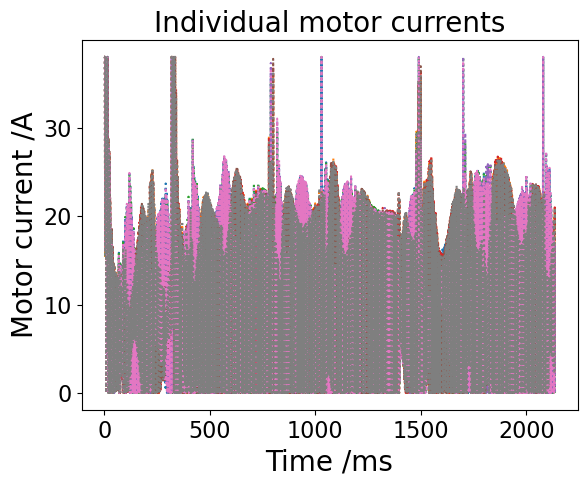

In [24]:
# Currents
plt.plot(log.currents, ls=':')
plt.ylabel('Motor current /A')
plt.title('Individual motor currents')
plt.xlabel('Time /ms')

Text(0.5, 1.0, 'Voltages')

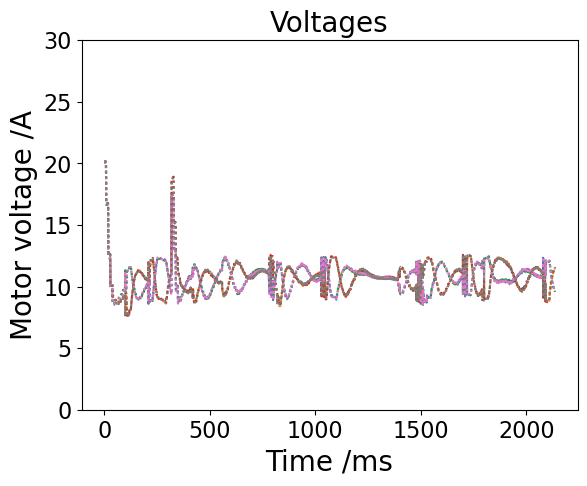

In [25]:
# Voltages
plt.plot(log.voltages, ls=':')
plt.ylim(0, 30)
plt.ylabel('Motor voltage /A')
plt.xlabel('Time /ms')
plt.title('Voltages')

{'pos': <Axes: title={'center': 'Position and Orientation'}, ylabel='Orientation /deg'>,
 'vel': <Axes: title={'center': 'Velocities'}>,
 'ctrl': <Axes: ylabel='Torque /Nm'>,
 'traj': <Axes: title={'center': 'XY positions /m'}, xlabel='X /m', ylabel='Y /m'>}

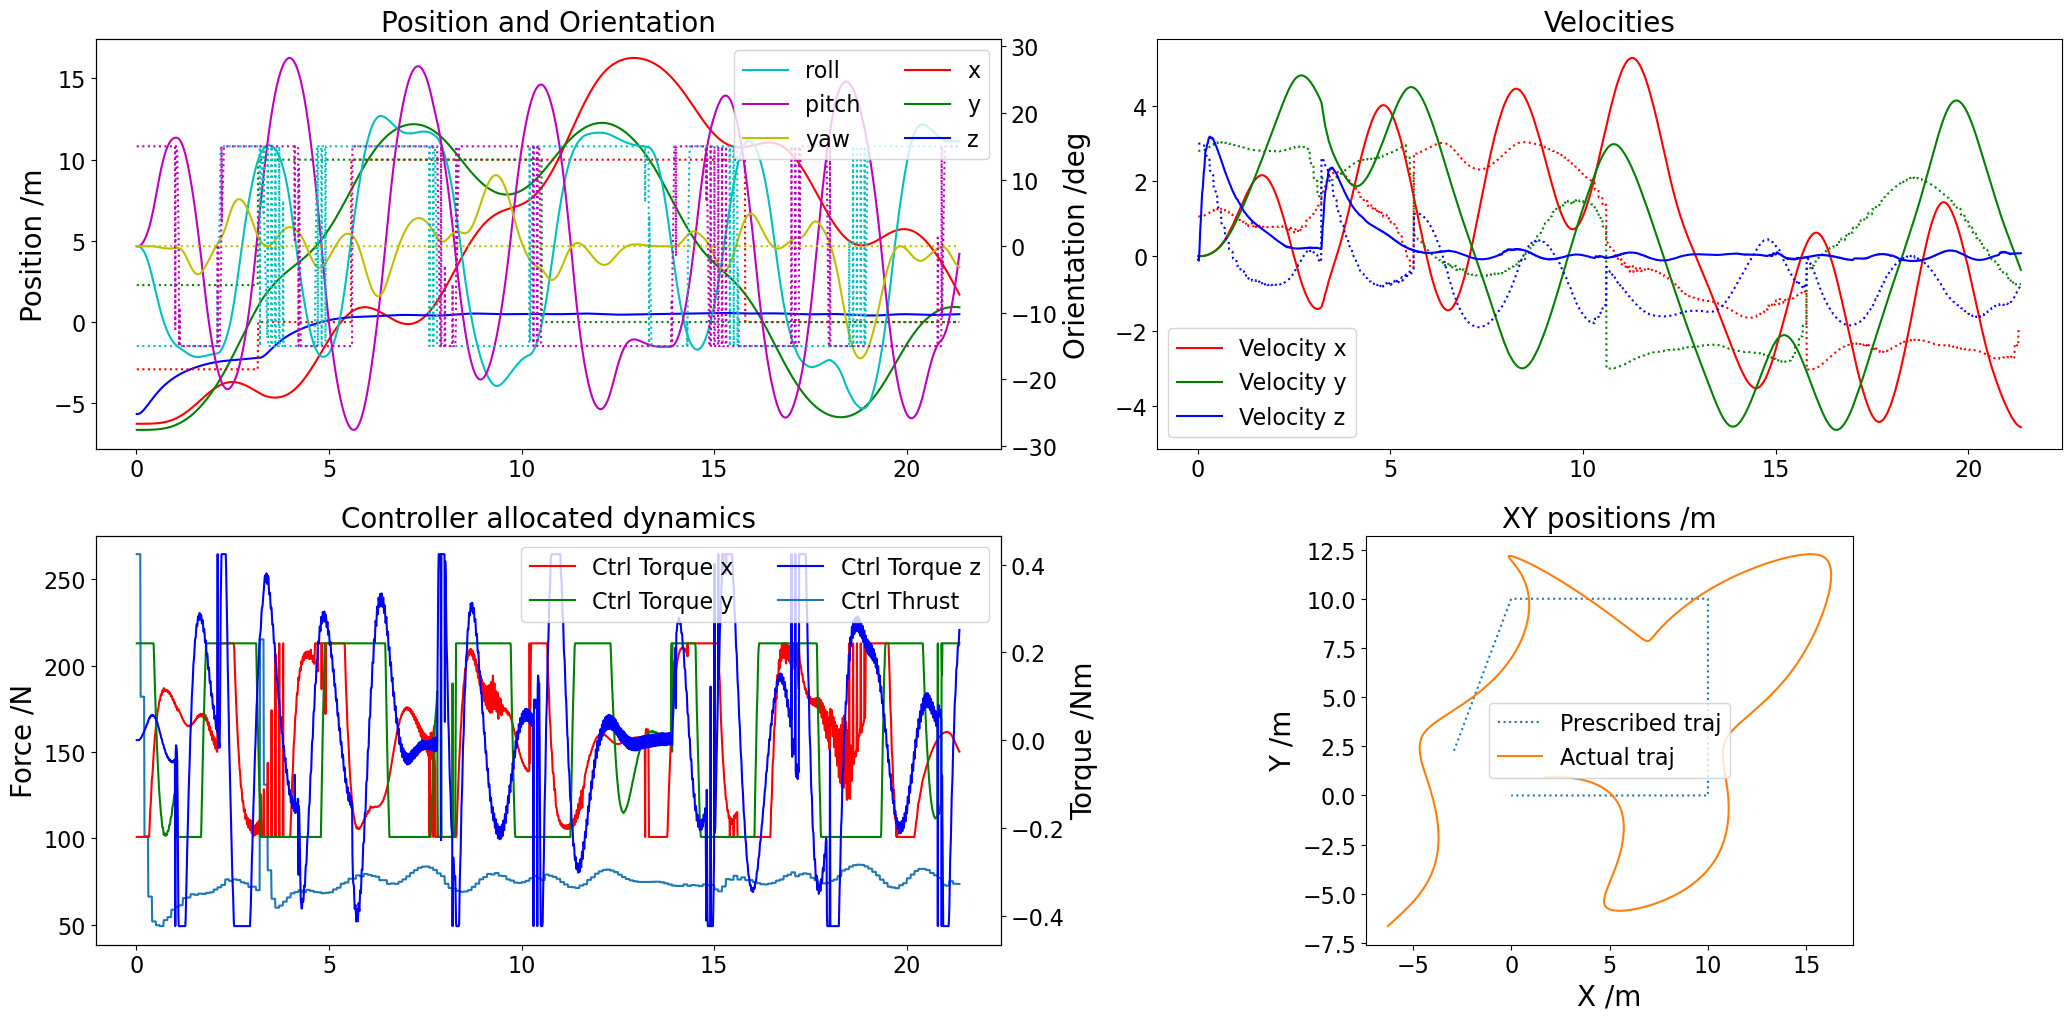

In [26]:
# PLot positions, velocities, prescribed dynamics
plot_datalog(log)

In [27]:
# 3D plot of trajectory
%matplotlib notebook
fig = plt.figure()
xlim = ylim = zlim = (np.min(log.position), np.max(log.position))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(log.x, log.y, log.z)

Loaded backend nbAgg version unknown.


<IPython.core.display.Javascript object>

In [28]:
import socket
import time
import json
import struct

In [52]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    velo = state[3:6].tolist()
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()

    # pos = [0, 0, 0]
    # velo = [0, 0, 0]
    # accel = [0, 0, 0]

    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : velo
    }
    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"

    return JSON_string


In [62]:
def ap_sim(env, sock, steps=60_000, disturbance=None):
    curr_time = time.monotonic()  # Get the current time in seconds
    time_step = 1/1200
    # TODO: add timing

    ap_log = DataLog(env.vehicle)
    custom_logger = {}
    
    disturb_force, disturb_torque = 0., 0
    for i in range(0, steps):
        try:   
            data, addr = sock.recvfrom(100)

            parse_format = 'HHI16H'
            magic = 18458

            if len(data) != struct.calcsize(parse_format):
                print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                continue
            unpacked_data = struct.unpack(parse_format, data)
            # print(unpacked_data)
            if magic != unpacked_data[0]:
                print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                continue

            frame_rate = unpacked_data[1]
            frame_count = unpacked_data[2]
            pwm = np.array(unpacked_data[3:11])

            time_step = 1/frame_rate
            curr_time += time_step

            # TODO: fix frame_rate/frame_count  
            # TODO: add wind/disturbances

            if disturbance is not None:
                disturb_force, disturb_torque = disturbance(i, env.vehicle)

            action = (pwm-1000)*0.575 # TODO: turn pwm to actions

            # action is n-size vector of speed of propellors (voltage signal, speed_voltage_scaling should be there?)
            # QUESTION: voltage signal vs pwm
            
            # state returned is (position, velocity, orientation, angular rate)
            # QUESTION: accel vs orientation, angular rate vs roll pitch yaw

            # print(action)
            state, *_ = env.step(
                action, disturb_forces=disturb_force, disturb_torques=disturb_torque
            )
            accel = env.vehicle.dxdt_speeds(0, state, action, disturb_forces=disturb_force, disturb_torques=disturb_torque)[3:6]
            JSON_string = changeToJSONString(curr_time, state, accel)
            # Send to AP
            sock.sendto(bytes(JSON_string,"ascii"), addr)
            # print(JSON_string)
            
            ap_log.log()
            custom_logger[i] = action.tolist()
            # log action??
        except json.JSONDecodeError:
            print("Invalid JSON data received")
        except socket.timeout:
            print("Did not recieve any data")
            pass  # Ignore socket timeouts
        except KeyboardInterrupt:
            sock.close()
        except Exception as e:
            if not isinstance(e, OSError):
                print(e)
            sock.close()

    ap_log.done_logging()    
    return ap_log, custom_logger


In [63]:

UDP_IP = "127.0.0.1"  # Listen on all available interfaces
UDP_PORT = 9002

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))
sock.settimeout(3)  # Set a timeout value of 1 second on the socket object

env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
env.reset()
ap_log, action_log = ap_sim(env, sock, steps=60_000, disturbance=None)

sock.close()


'Did not recieve any data'


{'pos': <Axes: title={'center': 'Position and Orientation'}, ylabel='Orientation /deg'>,
 'vel': <Axes: title={'center': 'Velocities'}>}

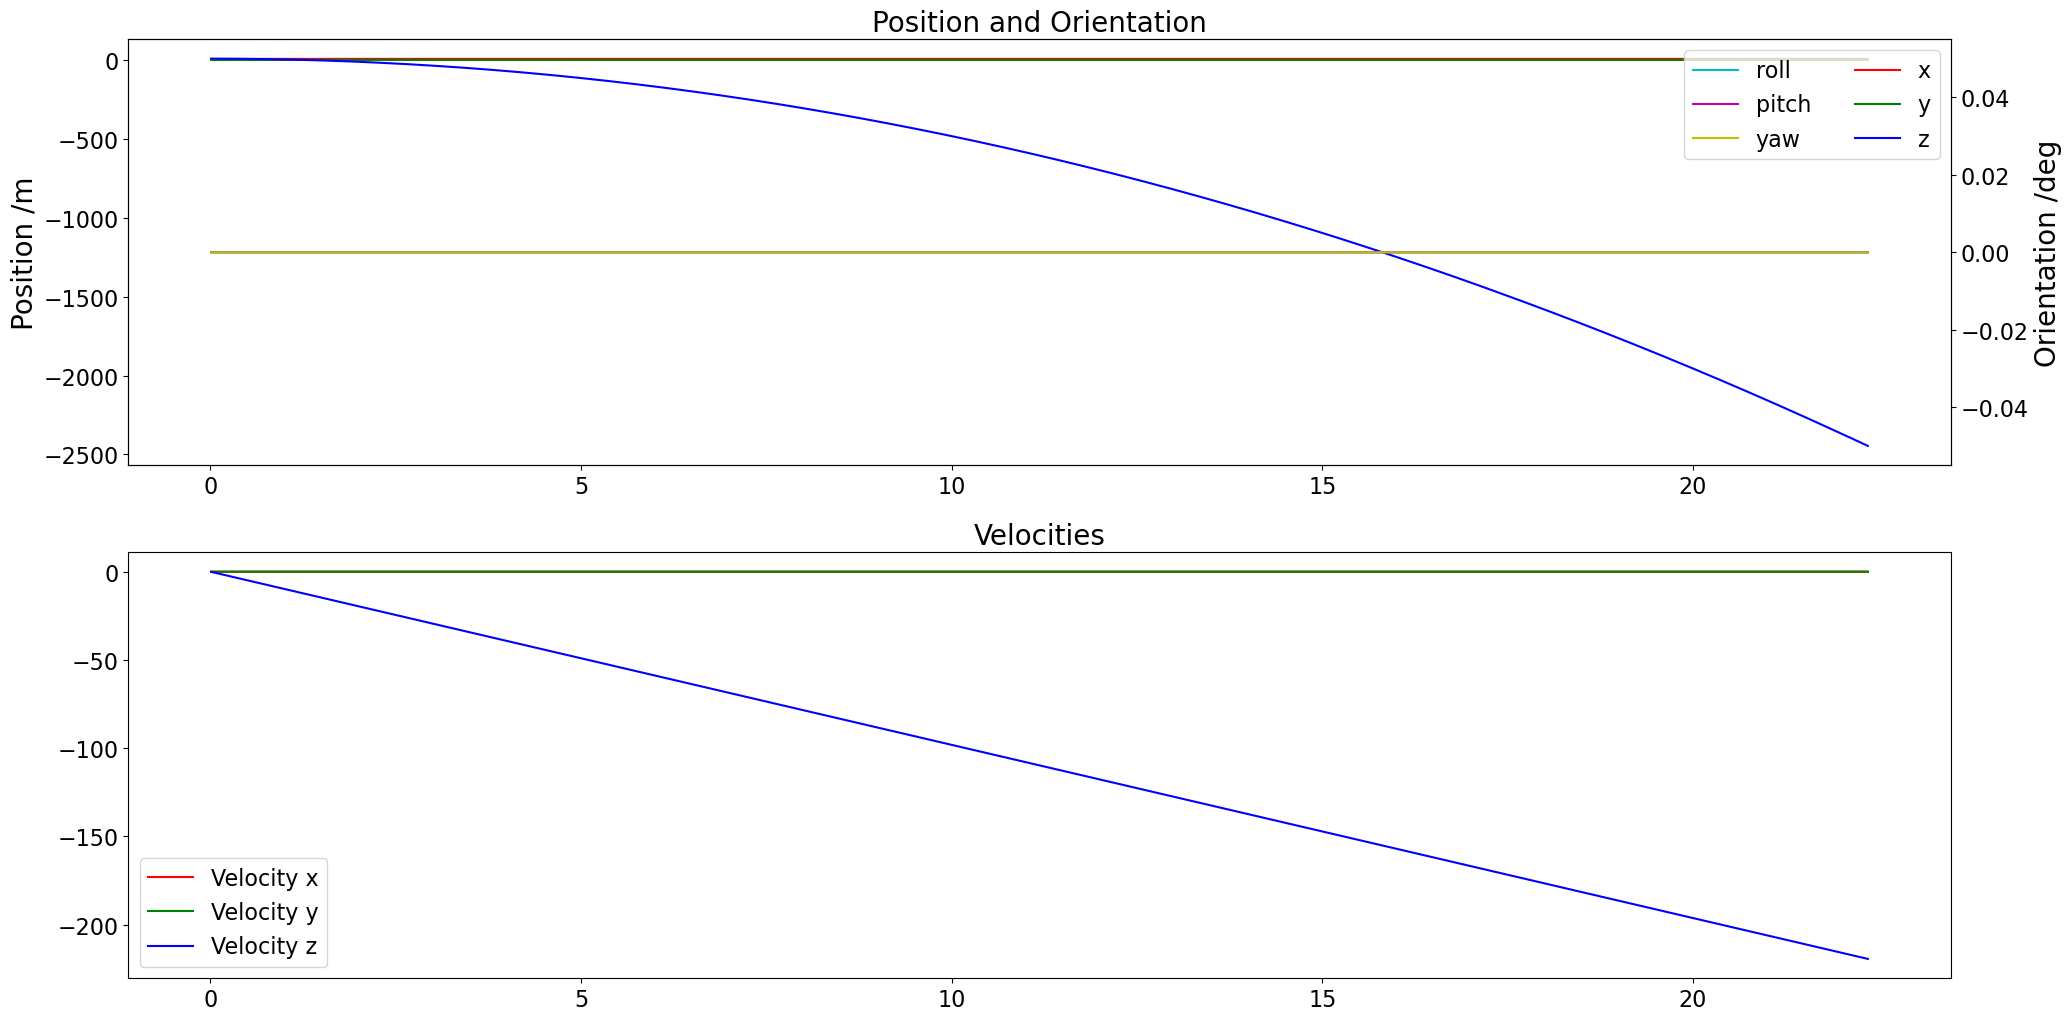

In [64]:
plot_datalog(ap_log, plots=('pos', 'vel'))

In [65]:
element_data = {}
for index in range(len(action_log[0])):
    element_data[index] = [data[index] for data in action_log.values()]

# Plot the data for each element
for index, data in element_data.items():
    plt.plot(list(action_log.keys()), data, label=f"Motor {index+1}")

# Set plot labels and title
plt.xlabel("Time Step")
plt.ylabel("Motor command")
plt.title("Change of Motor Command over Time")

# Add legend
plt.legend()

# Display the plot
plt.show()

TypeError: object of type 'NoneType' has no len()